In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
import importlib
import wrds
import os
import hdbscan

from scipy.spatial.distance import squareform, pdist
from functools import reduce
import seaborn as sns; sns.set_theme(color_codes=True);
import umap.umap_ as umap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, AffinityPropagation, SpectralClustering, OPTICS
from sklearn.mixture import GaussianMixture

import wrds_loader

In [2]:
importlib.reload(wrds_loader)
sp_500 = wrds_loader.download_snp_constituents()
sp_500

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


,permno,start,ending,date,ret,prc,shrout,comnam,ncusip,namedt,...,shrcd,exchcd,hsiccd,ticker,gvkey,iid,linktype,linkprim,linkdt,linkenddt
1,20853.0,1941-08-20,2000-10-20,2000-01-31,0.167910,39.125000,217517.0,UNICOM CORP HOLDING CO,90491110,1994-09-01,...,11.0,1.0,4911.0,UCM,003255,01,LC,P,1962-01-31,2000-10-20 00:00:00.000000
4,26075.0,1966-09-29,2000-11-01,2000-01-31,-0.004353,57.187500,27020.0,EASTERN ENTERPRISES,27637F10,1989-05-01,...,11.0,1.0,4449.0,EFU,004189,01,LU,C,1962-01-31,2000-11-08 00:00:00.000000
6,14891.0,1957-03-01,2005-08-10,2000-01-31,-0.141155,28.625000,242418.0,UNOCAL CORP,91528910,1983-04-25,...,11.0,1.0,1311.0,UCL,011038,01,LC,P,1962-01-31,2005-08-10 00:00:00.000000
7,26438.0,1964-01-30,2000-12-11,2000-01-31,0.262458,23.750000,44525.0,POLAROID CORP,73109510,1968-01-02,...,11.0,1.0,3861.0,PRD,008657,01,LU,P,1962-01-31,2001-10-09 00:00:00.000000
9,14541.0,1925-12-31,2022-12-30,2000-01-31,-0.034632,83.625000,656266.0,CHEVRON CORP,16675110,1984-04-02,...,11.0,1.0,5541.0,CHV,002991,01,LU,P,1962-01-31,2023-12-07 23:32:44.104039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175131,23579.0,1978-10-05,2022-12-30,2022-12-30,-0.007845,70.800003,208771.0,TEXTRON INC,88320310,2021-04-01,...,11.0,1.0,3721.0,TXT,010519,01,LC,P,1962-01-31,2023-12-07 23:32:44.104039
175132,22623.0,2022-02-02,2022-12-30,2022-12-30,-0.103100,86.209999,327018.0,CONSTELLATION ENERGY CORP,21037T10,2022-02-02,...,11.0,3.0,9999.0,CEG,040614,01,LC,P,2022-02-02,2023-12-07 23:32:44.104039
175133,76185.0,2020-06-22,2022-12-30,2022-12-30,-0.059316,322.410004,41640.0,TYLER TECHNOLOGIES INC,90225210,2006-06-30,...,11.0,1.0,7372.0,TYL,010789,01,LC,P,1990-05-22,2023-12-07 23:32:44.104039
175134,75591.0,2019-08-09,2022-12-30,2022-12-30,-0.038570,228.330002,75421.0,IDEX CORP,45167R10,2020-03-19,...,11.0,1.0,3561.0,IEX,015267,01,LU,P,1989-06-02,2023-12-07 23:32:44.104039


In [ ]:
importlib.reload(wrds_loader)
tickers = sp_500['ticker'].unique()
conn = wrds.Connection()
for ticker in tickers:
    data = wrds_loader.download_stock_data_crsp([ticker], conn=conn)
    data.to_feather(f'returns/{ticker}.feather')
conn.close()

In [ ]:
# # List all files in the directory
# directory_path = 'returns'
# files = os.listdir(directory_path)
# all_df = []
# # Iterate through each file in the directory
# for filename in files:
#     file_path = os.path.join(directory_path, filename)
#     all_df.append(pd.read_feather(file_path))
#     print(f'{filename} Done')
df = pd.concat(all_df, ignore_index=True)
df

#### Momentum

In [ ]:
eps = 10 ** (-5)
def rolling_prod(series, window):
    """
    Compute rolling product over a window for a given series.
    """
    # Compute rolling product for entire series first
    rolling_cumprod = series.cumprod()

    # Compute rolling product over a given window by dividing the rolling cumprod at
    # the end of the window by the rolling cumprod at the beginning of the window
    return rolling_cumprod / rolling_cumprod.shift(window)

def calc_momentum(feather_path, spy_momentum=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])
    
    df['momentum'] = rolling_prod((1+df['ret']), 11 * 20) - 1
    df['momentum'] = df['momentum'].shift(20)
    
    if spy_momentum is not None:
        df = pd.merge(df, spy_momentum, on='date', how='inner')
        df['risk_adj_momentum'] = (eps + df['momentum']) / (eps + df['spy_momentum'])
    return df

# Load and preprocess SPY data
spy = calc_momentum('returns/SPY.feather')
spy = spy[['date', 'momentum']]
spy.columns = ['date', 'spy_momentum']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_momentum(file_path, spy_momentum=spy)
    df = df[['ticker', 'date', 'momentum', 'risk_adj_momentum']]
    df.to_csv(f'factors/momentum/{filename[:-7] + "csv"}', index=False)
    print(f'{filename} Done')

In [ ]:
aapl = pd.read_feather('factors/momentum/AAPL.feather')
msft = pd.read_feather('factors/momentum/MSFT.feather')
nvda = pd.read_feather('factors/momentum/NVDA.feather')
goog = pd.read_feather('factors/momentum/GOOG.feather')
spy = pd.read_feather('factors/momentum/SPY.feather')

aapl = aapl[aapl['date'].dt.year > 2010]
msft = msft[msft['date'].dt.year > 2010]
nvda = nvda[nvda['date'].dt.year > 2010]
goog = goog[goog['date'].dt.year > 2010]
spy = spy[spy['date'].dt.year > 2010]

plt.figure(figsize=(25,15))
plt.title('Momentum')
plt.grid(linestyle='--', color='silver')

plt.plot(aapl['date'], aapl['momentum'], label='AAPL')
plt.plot(msft['date'], msft['momentum'], label='MSFT')
plt.plot(nvda['date'], nvda['momentum'], label='NVDA')
plt.plot(goog['date'], goog['momentum'], label='GOOG')
plt.plot(spy['date'], spy['momentum'], label='SPY')

plt.legend()
plt.show()

#### 1 month reversal

In [ ]:
def calc_reversal(feather_path, spy_reversal=None):
    df = pd.read_feather(feather_path)
    df['date'] = pd.to_datetime(df['date'])
    df = df[['ticker', 'date', 'ret', 'shrout', 'prc']].drop_duplicates(subset=['ticker', 'date'])

    df['1M_reversal*'] = (1/rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    df['1M_reversal'] = (-rolling_prod((1+df['ret']), 20)).shift(1).fillna(eps)
    
    if spy_reversal is not None:
        df = pd.merge(df, spy_reversal, on='date', how='inner')
        df['risk_adj_1M_reversal'] = (eps + df['1M_reversal']) / (eps + df['spy_1M_reversal'])
        df['risk_adj_1M_reversal*'] = (eps + df['1M_reversal*']) / (eps + df['spy_1M_reversal*'])
    return df

# Load and preprocess SPY data
spy = calc_reversal('returns/SPY.feather')
spy = spy[['date', '1M_reversal', '1M_reversal*']]
spy.columns = ['date', 'spy_1M_reversal', 'spy_1M_reversal*']
spy = spy[spy['date'].dt.year >= 1993]

# Specify the directory path
directory_path = 'returns'

# List all files in the directory
files = os.listdir(directory_path)

# Iterate through each file in the directory
for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = calc_reversal(file_path, spy_reversal=spy)
    df = df[['ticker', 'date', '1M_reversal', '1M_reversal*', 'risk_adj_1M_reversal', 'risk_adj_1M_reversal*']]
    filename = filename.split(".")[0] + ".csv"
    df.to_csv(f'factors/1_month_reversal/{filename}')
    print(f'{filename} Done')

#### Financial Ratios

In [3]:
importlib.reload(wrds_loader)
directory_path = 'returns'
files = os.listdir(directory_path)
conn = wrds.Connection()
for filename in files:
    ticker = filename.split(".")[0]
    data = wrds_loader.download_finratios(ticker, db=conn)
    data.to_csv(f'factors/finratios/{ticker}.csv')
    print(f'{ticker} Done')
conn.close()

Enter your WRDS username [food4thought]:akashmr1096
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: n
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done
A Done
AA Done
AAL Done
AAP Done
AAPL Done
ABBV Done
ABC Done
ABI Done
ABK Done
ABMD Done
ABS Done
ABT Done
ABX Done
ACAS Done
ACE Done
ACGL Done
ACK Done
ACN Done
ACS Done
ACT Done
ACV Done
ADBE Done
ADCT Done
ADI Done
ADM Done
ADNT Done
ADP Done
ADPT Done
ADS Done
ADSK Done
ADT Done
AEE Done
AEP Done
AES Done
AET Done
AFL Done
AFS Done
AGC Done
AGN Done
AHC Done
AHP Done
AIG Done
AIV Done
AIZ Done
AJG Done
AKAM Done
AKS Done
AL Done
ALB Done
ALGN Done
ALK Done
ALL Done
ALLE Done
ALTR Done
ALXN Done
AM Done
AMAT Done
AMCC Done
AMCR Done
AMD Done
AME Done
AMG Done
AMGN Done
AMP Done
AMR Done
AMT Done
AMZN Done
AN Done
ANDV Done
ANDW Done
ANET Done
ANF Done
ANR Done
ANSS Done
ANTM Done
AOC Done
AOL Done
AON Done
AOS Do

SCHW Done
SDS Done
SE Done
SEBL Done
SEDG Done
SEE Done
SEG Done
SFA Done
SGI Done
SGP Done
SHLD Done
SHW Done
SIAL Done
SIG Done
SII Done
SIVB Done
SJM Done
SLB Done
SLE Done
SLG Done
SLM Done
SLR Done
SMI Done
SMS Done
SNA Done
SNDK Done
SNI Done
SNPS Done
SNV Done
SO Done
SOTR Done
SOV Done
SPC Done
SPG Done
SPGI Done
SPLS Done
SPY Done
SRCL Done
SRE Done
SRV Done
SSP Done
STA Done
STE Done
STI Done
STJ Done
STLD Done
STR Done
STT Done
STX Done
STZ Done
SUB Done
SUN Done
SUNW Done
SV Done
SVU Done
SWK Done
SWKS Done
SWN Done
SWY Done
SYF Done
SYK Done
SYMC Done
SYY Done
T Done
TAN Done
TAP Done
TDC Done
TDG Done
TDY Done
TE Done
TECH Done
TEG Done
TEK Done
TEL Done
TER Done
TEX Done
TFC Done
TFX Done
TGNA Done
TGT Done
THC Done
TIE Done
TIF Done
TIN Done
TJX Done
TKR Done
TLAB Done
TMC Done
TMK Done
TMO Done
TMPW Done
TMUS Done
TNB Done
TOS Done
TOY Done
TPR Done
TRB Done
TRGP Done
TRIP Done
TRMB Done
TROW Done
TRV Done
TRW Done
TSCO Done
TSG Done
TSLA Done
TSN Done
TSO Done
TSS Don

In [ ]:
directory_path = 'factors/1_month_reversal'
files = os.listdir(directory_path)
data = []
for filename in files:
    file_path = os.path.join(directory_path, filename)
    data.append(pd.read_csv(file_path))
pd.concat(data, axis=0, ignore_index=True).to_csv('1m_reversal_all.csv')

In [ ]:
directory_path = 'factors/finratios'
files = os.listdir(directory_path)
data = []
for filename in files:
    file_path = os.path.join(directory_path, filename)
    data.append(pd.read_csv(file_path))
pd.concat(data, axis=0, ignore_index=True).to_csv('finratios_all.csv')

# CLUSTERING

In [ ]:
directory_path = 'returns'
files = os.listdir(directory_path)

dfs = []  # A list to store DataFrames

for filename in files:
    file_path = os.path.join(directory_path, filename)
    df = pd.read_feather(file_path)
    df = df[['ticker', 'date', 'ret']]
    ticker = filename.split('.feather')[0]
    df['date'] = pd.to_datetime(df['date'])
    df = df[df['date'].dt.year == 2021]
    df.rename(columns={'ret': ticker}, inplace=True)
    df.drop(columns=['ticker'], inplace=True)
    dfs.append(df.reset_index(drop=True))

In [ ]:
dfs = [df.drop_duplicates(subset=['date']) for df in dfs]
merged_df = reduce(lambda x, y: pd.merge(x, y, on='date', how='left'), dfs)
merged_df

In [ ]:
returns_df = merged_df.set_index('date')
returns_df = returns_df.drop(columns='SPY')
nan_percentage = (returns_df.isnull().sum() / len(returns_df)) * 100
threshold = 100
columns_to_drop = nan_percentage[nan_percentage >= threshold].index
returns_df = returns_df.drop(columns=columns_to_drop)
returns_df = returns_df.T
returns_df = returns_df.fillna(0)
returns_df

### HDBSCAN

In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(returns_df)

# Apply HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, metric='manhattan')
cluster_labels = clusterer.fit_predict(df_scaled)
returns_df['HDBSCAN'] = cluster_labels 

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with HDBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### KMeans

In [ ]:
# Function to calculate WCSS for KMeans
def calculate_wcss(data):
    wcss = []
    for n in range(1, 101): # Let's test for 1 to 10 clusters
        kmeans = KMeans(n_clusters=n)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
    return wcss

# Plot the WCSS to find the elbow
#wcss = calculate_wcss(df_scaled)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 101), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# Define the number of clusters for KMeans and GMM
n_clusters = 80

# K-Means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(df_scaled)
returns_df['KMeans'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters without a legend
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))  # 'hsv' is cyclic, better for many clusters
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with KMeans Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### GMM

In [ ]:
# Function to calculate BIC and AIC
def calculate_bic_aic(data):
    bics = []
    aics = []
    for n in range(1, 101): # Let's test for 1 to 10 clusters
        gmm = GaussianMixture(n_components=n)
        gmm.fit(data)
        bics.append(gmm.bic(data))
        aics.append(gmm.aic(data))
    return bics, aics

# Plot the BIC and AIC
#bics, aics = calculate_bic_aic(df_scaled)
plt.figure(figsize=(10, 8))
plt.plot(range(1, 101), bics, label='BIC')
plt.plot(range(1, 101), aics, label='AIC')
plt.legend()
plt.title('BIC and AIC Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Scores')
plt.show()

In [ ]:
# Define the number of clusters for GMM
n_clusters = 20

# Gaussian Mixture Model clustering
gmm = GaussianMixture(n_components=n_clusters, random_state=42)
cluster_labels = gmm.fit_predict(df_scaled)
returns_df['GMM'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters without a legend
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))  # 'hsv' is cyclic, better for many clusters
sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with GMM Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### DBSCAN

In [ ]:
# DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=2)
cluster_labels = dbscan.fit_predict(df_scaled)
returns_df['DBSCAN'] = cluster_labels

# Apply UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

# Plot the clusters
plt.figure(figsize=(8, 6))
palette = sns.color_palette('hsv', len(set(cluster_labels)))

sns.scatterplot(*embedding.T, hue=cluster_labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
plt.title('UMAP plot with DBSCAN Clusters')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

### Other Clustering Models

In [ ]:
def apply_clustering(model, data):
    # Fit the model and predict the cluster labels
    cluster_labels = model.fit_predict(data)
    return cluster_labels

# List of clustering models to apply
clustering_models = [
    MeanShift(),  # May need bandwidth parameter adjusted
    AffinityPropagation(),  # Beware, complexity can be high
    SpectralClustering(n_clusters=n_clusters, random_state=42, affinity='nearest_neighbors'),
    OPTICS(min_samples=5, xi=0.05, min_cluster_size=10),  # Adjust parameters as needed
]

clustering_labels = {}

for model in clustering_models:
    model_name = model.__class__.__name__
    clustering_labels[model_name] = apply_clustering(model, df_scaled)
    returns_df[model_name] = clustering_labels[model_name]

reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_scaled)

for model_name, labels in clustering_labels.items():
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette('hsv', len(np.unique(labels)))  # Adjust the palette as needed
    sns.scatterplot(*embedding.T, hue=labels, palette=palette, s=50, alpha=0.8, edgecolor=None, legend=False)
    plt.title(f'UMAP plot with {model_name} Clusters')
    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.show()

In [ ]:
clusters = returns_df[returns_df.columns[-8:]]
clusters = clusters.reset_index()
clusters.rename(columns={'index': 'Ticker'}, inplace=True)
clusters.to_csv('stock_clusters.csv', index=False)
clusters = pd.read_csv('stock_clusters.csv')
clusters

# Portfolio Construction

In [100]:
start_date = pd.to_datetime('2021-01-01')
end_date = pd.to_datetime('2021-12-31')
ticker_list = get_tickers(start_date, end_date, sp_500)
ticker_list = np.append(ticker_list, 'SPY')

In [101]:
def get_tickers(start_date, end_date, sp500):
    sp500['date'] = pd.to_datetime(sp500['date'])
    return sp500.loc[(sp500['date'] >= start_date) & (sp500['date'] <= end_date), 'ticker'].unique()
    
def get_weeks_df(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date, inclusive='both')
    all_dates_df = pd.DataFrame({'date': date_range})
    all_dates_df.set_index('date', inplace=True)
    all_dates_df = all_dates_df.resample('W-MON').first()
    all_dates_df.reset_index(inplace=True)
    return all_dates_df
    
def weekly_returns(start_date, end_date, ticker_list):
    # Specify the directory path
    directory_path = 'returns'

    # List all files in the directory
    files = os.listdir(directory_path)
    all_dfs = []
    
    # Date Range
    all_dates_df = get_weeks_df(start_date, end_date)
    time_diff = (end_date - start_date).days
    
    # Iterate through each file in the directory
    for ticker in ticker_list:
        filename = ticker + '.feather'
        file_path = os.path.join(directory_path, filename)
        #print(file_path)
        df = pd.read_feather(file_path)
        df['date'] = pd.to_datetime(df['date'])
        df = df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]
        df = df.dropna(subset=['ret'])
        
        if len(df) >= (0.6 * time_diff):
            df['ret'] = 1 + df['ret']
            df.set_index('date', inplace=True)
            df = df.resample('W-MON').agg({'ticker': 'last', 'ret': 'prod'})
            df['ret'] = df['ret'] - 1
            df.reset_index(inplace=True)
            df = pd.merge(all_dates_df, df, how='left', on=['date']).drop_duplicates(subset='date').sort_values(by='date').reset_index(drop=True)
            #print(df)
            ticker = df['ticker'].iloc[df['ticker'].first_valid_index()]
            df['ticker'] = df['ticker'].fillna(ticker)
            all_dfs.append(df)

            print(f"", end=' ')
            
    merged_df = all_dates_df
    for df in all_dfs:
        ticker = df['ticker'].iloc[0]
        df = df.rename(columns={'ret': ticker})
        df.drop(columns=['ticker', 'date'], inplace=True)
        merged_df = pd.concat([merged_df, df], axis=1)
    
    return merged_df.fillna(0).set_index('date')

def get_series(all_dates_df, factor_df, factor_name, ticker):
    factor_df['date'] = pd.to_datetime(factor_df['date'])
    merged_df = pd.merge(factor_df, all_dates_df, on='date', how='outer').drop_duplicates(subset=['date']).sort_values(by='date').fillna(method='ffill')
    merged_df = pd.merge(all_dates_df, merged_df, on='date', how='inner').sort_values(by='date').fillna(method='ffill')
    
    series = pd.to_numeric(merged_df[factor_name])
    series.name = ticker
    return series

def get_factors(start_date, end_date, ticker_list):
    factors_dict = {}
    all_dates_df = get_weeks_df(start_date, end_date)
    
    fact_list = ['momentum', 'risk_adj_momentum', 'pe_op_basic', 'bm', '1M_reversal', 'risk_adj_1M_reversal']
    for fact in fact_list:
        factors_dict[fact] = []
    
    momentum_path = 'factors/momentum'
    finratios_path = 'factors/finratios'
    reversal_path = 'factors/1_month_reversal'
    
    data = []
    counter = 0

    for ticker in ticker_list:
        filename = ticker + '.csv'
        
        momentum = pd.read_csv(os.path.join(momentum_path, filename))[['date', 'momentum', 'risk_adj_momentum']]
        finratio = pd.read_csv(os.path.join(finratios_path, filename))[['date', 'pe_op_basic', 'bm']]
        reversal = pd.read_csv(os.path.join(reversal_path, filename))[['date', '1M_reversal*', 'risk_adj_1M_reversal*']]
        
        factors_dict['momentum'].append(get_series(all_dates_df, momentum, 'momentum', ticker))
        factors_dict['risk_adj_momentum'].append(get_series(all_dates_df, momentum, 'risk_adj_momentum', ticker))
        factors_dict['pe_op_basic'].append(get_series(all_dates_df, finratio, 'pe_op_basic', ticker))
        factors_dict['bm'].append(get_series(all_dates_df, finratio, 'bm', ticker))
        factors_dict['1M_reversal'].append(get_series(all_dates_df, reversal, '1M_reversal*', ticker))
        factors_dict['risk_adj_1M_reversal'].append(get_series(all_dates_df, reversal, 'risk_adj_1M_reversal*', ticker))
        
        #print(f'{ticker}', end=' ')
    
    for fact in fact_list:
        factors_dict[fact] = pd.concat(factors_dict[fact], axis=1)
        factors_dict[fact]['date'] = pd.to_datetime(all_dates_df['date'])
        factors_dict[fact].set_index('date', inplace=True)
    
    return factors_dict

def market_cap_wts(sp_500, start_date, end_date, ticker_list):
    df = sp_500.loc[sp_500['date'] >= (start_date - pd.DateOffset(days=35))].loc[sp_500['date'] <= (end_date + pd.DateOffset(days=35))]
    df['mcap'] = df['prc'] * df['shrout'] * 1000
    df = df[['ticker', 'date', 'mcap']]
    pivot_df = df.pivot(index='date', columns='ticker', values='mcap')
    pivot_df.columns.name = None
    columns_to_drop = [col for col in pivot_df.columns if col not in ticker_list]
    pivot_df.drop(columns=columns_to_drop, inplace=True)
    pivot_df.reset_index(inplace=True)
    weekly_dates = get_weeks_df(start_date, end_date)
    df = pd.merge(pivot_df, weekly_dates, on='date', how='outer').drop_duplicates('date').sort_values(by='date').fillna(method='ffill').fillna(method='bfill')
    df = pd.merge(df, weekly_dates, on='date', how='inner').sort_values(by='date')
    series = df['date']
    df.drop(columns=['date'], inplace=True)
    df = df.div(df.sum(axis=1), axis=0)
    df['date'] = pd.to_datetime(series)
    df.set_index('date', inplace=True)
    return df

def render_returns_data_for_clustering(start_date, end_date, ticker_list):
    directory_path = 'returns'
    files = os.listdir(directory_path)
    new_start_date = start_date - pd.DateOffset(days=365)
    new_end_date = end_date - pd.DateOffset(days=365)

    dfs = []  # A list to store DataFrames

    for ticker in ticker_list:
        filename = ticker + '.feather'
        file_path = os.path.join(directory_path, filename)
        df = pd.read_feather(file_path)
        df = df[['ticker', 'date', 'ret']]
        ticker = filename.split('.feather')[0]
        df['date'] = pd.to_datetime(df['date'])
        df = df[(df['date'] >= new_start_date) & (df['date'] <= new_end_date)]
        df.rename(columns={'ret': ticker}, inplace=True)
        df.drop(columns=['ticker'], inplace=True)
        dfs.append(df.reset_index(drop=True))
        
    dfs = [df.drop_duplicates(subset=['date']) for df in dfs]
    merged_df = reduce(lambda x, y: pd.merge(x, y, on='date', how='left'), dfs)
    
    returns_df = merged_df.set_index('date')
    returns_df = returns_df.drop(columns='SPY')
    nan_percentage = (returns_df.isnull().sum() / len(returns_df)) * 100
    threshold = 100
    columns_to_drop = nan_percentage[nan_percentage >= threshold].index
    returns_df = returns_df.drop(columns=columns_to_drop)
    returns_df = returns_df.T
    returns_df = returns_df.fillna(0)
    
    scaler = StandardScaler()
    return returns_df, scaler.fit_transform(returns_df)

def get_clusters(start_date, end_date, ticker_list):
    dfs = [] 
    returns_df, df_scaled = render_returns_data_for_clustering(start_date, end_date, ticker_list)
   
    # List of clustering models to apply
    clustering_models = [
        AffinityPropagation(),  # Beware, complexity can be high
        SpectralClustering(n_clusters=80, random_state=42, affinity='nearest_neighbors'),
        KMeans(n_clusters=80, random_state=42),
        GaussianMixture(n_components=80, random_state=42)
    ]

    clustering_labels = pd.DataFrame(index=returns_df.index)

    for model in clustering_models:
        model_name = model.__class__.__name__
        clustering_labels[model_name] = apply_clustering(model, df_scaled)
        #returns_df[model_name] = clustering_labels[model_name]

    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(df_scaled)
    clustering_labels.reset_index(inplace=True)
    clustering_labels.rename(columns={clustering_labels.columns[0]: 'Ticker'}, inplace=True)
    clustering_labels = clustering_labels.T
    clustering_labels.columns = clustering_labels.iloc[0]
    clustering_labels = clustering_labels[1:]
    clustering_labels.columns.name = None
    cluster_dict = {}
    for i in range(len(clustering_labels)):
        cluster_dict[clustering_labels.index[i]] = clustering_labels.loc[clustering_labels.index[i] == clustering_labels.index].reset_index(drop=True)
    return cluster_dict

def apply_clustering(model, data):
    # Fit the model and predict the cluster labels
    cluster_labels = model.fit_predict(data)
    return cluster_labels

def normalize(weights):
    weights = weights.copy()
    total_sum = weights.abs().sum(axis=1)
    normalized_weights = weights.div(total_sum + 10e-12, axis=0)
    return normalized_weights

def enforce_boundary(weights, max_weights, min_weights):
    weights = normalize(weights)
    max_exceeded = weights.abs() > max_weights
    min_exceeded = weights.abs() < min_weights

    if max_exceeded.any().any():
        weights[max_exceeded] = max_weights * weights[max_exceeded].abs()/weights[max_exceeded]

    if min_exceeded.any().any():
        weights[min_exceeded] = min_weights * weights[min_exceeded].abs()/weights[min_exceeded]

    return normalize(weights)

def add_to_print(print_df, scheme, period_returns, weights_df):
    returns = period_returns * weights_df
    returns = (returns.sum(axis=1) * 100).round(4)
    returns.name = scheme
    print_df = pd.concat([print_df, returns], axis=1)
    return print_df

def run_framework(start_date, end_date, market_cap_wt_df, factor_dict, returns_df, ticker_list):
    print_df = pd.DataFrame()
    returns = returns_df.copy()
    market_cap_wt = market_cap_wt_df.copy()
    
    spy_returns = returns['SPY']
    spy_returns.name = 'SPY'
    returns.drop(columns = ['SPY'], inplace=True)
    market_cap_wt = market_cap_wt[returns.columns]
    
    print('Generating Clusters')
    cluster_dict = get_clusters(start_date, end_date, ticker_list)
    
    print_df = pd.concat([print_df, (spy_returns * 100).round(4)], axis=1)
    portfolio_returns = []

    print('Calculating Returns For Factors')
    for key in factor_dict:
        weights = factor_dict[key].copy()
        max_wt, min_wt = 5/100, 0.01/100
        weights = enforce_boundary(weights, max_wt, min_wt)
        print_df = add_to_print(print_df, key, returns, weights)
        
    for key in cluster_dict:
        cluster_df = cluster_dict[key]
        for column in returns.columns:
            if column not in cluster_df.columns:
                cluster_df[column] = -1
        cluster_df = cluster_df[returns.columns]
        cluster_df = cluster_df.T
        cluster_df.columns = ['Cluster']
        
        for cluster in cluster_df['Cluster'].unique():
            cluster_mask = cluster_df['Cluster'] == cluster
            cluster_wt_df = market_cap_wt.copy()
            for stock in cluster_wt_df.columns:
                if not cluster_mask[stock]:
                    cluster_wt_df[stock] = 0.0

            # Add the DataFrame to the dictionary
            max_wt, min_wt = market_cap_wt * 5, market_cap_wt / 5
            weights = enforce_boundary(cluster_wt_df, max_wt, min_wt)
            print_df = add_to_print(print_df, str(key)+'-'+str(cluster), returns, weights)
        
        for factor_key in factor_dict:
            factor_df = factor_dict[factor_key].copy()
            
            # Calculate cluster weights
            cluster_weights = factor_df.groupby(cluster_df['Cluster'], axis=1).sum()

            # Calculate total market cap for each cluster
            market_cap_sum = market_cap_wt.groupby(cluster_df['Cluster'], axis=1).sum()

            adjusted_market_cap_wt = market_cap_wt.copy()
            for stock in market_cap_wt.columns:
                cluster = cluster_df.loc[stock, 'Cluster']
                adjusted_market_cap_wt[stock] = market_cap_wt[stock] / market_cap_sum[cluster]

            # Initialize a DataFrame for final weights
            final_weights = pd.DataFrame(index=adjusted_market_cap_wt.index, columns=returns.columns)

            # Multiply each stock's adjusted market cap weight by its cluster's weight
            for stock in adjusted_market_cap_wt.columns:
                cluster = cluster_df.loc[stock, 'Cluster']
                final_weights[stock] = adjusted_market_cap_wt[stock] * cluster_weights[cluster]

            print(cluster_weights)
            print(final_weights)
            print(max_wt)
            
            weights = enforce_boundary(final_weights, max_wt, min_wt)
            print_df = add_to_print(print_df, f'{key}-{factor_key}-mcap', returns, weights)
        
    save_csv(print_df.T)
    print('Save to CSV Complete')
    return returns, factor_dict
    
def save_csv(data_frame, base_folder='ReturnSeries', file_name_prefix="FactorReturns"):
    today_date = datetime.datetime.now().strftime("%Y-%m-%d")
    folder_path = os.path.join(base_folder, today_date)
    os.makedirs(folder_path, exist_ok=True)
    existing_files = [file for file in os.listdir(folder_path) if file.startswith(file_name_prefix)]
    new_file_name = f"{file_name_prefix}V{len(existing_files) + 1}.csv"
    file_path = os.path.join(folder_path, new_file_name)
    data_frame.to_csv(file_path)
    return file_path

In [102]:
market_cap_wt = market_cap_wts(sp_500, start_date, end_date, ticker_list)
factor_dict = get_factors(start_date, end_date, ticker_list)
returns = weekly_returns(start_date, end_date, ticker_list)

In [103]:
returns, factor_dict = run_framework(start_date, end_date, market_cap_wt, factor_dict, returns, ticker_list)

Generating Clusters


D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
D:\Applications\Anaconda\lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Calculating Returns For Factors
Cluster           1         2         3          5         6         7   \
date                                                                      
2021-01-04 -0.063106 -0.227761 -0.171540   1.597787 -1.374489 -0.551632   
2021-01-11 -0.018815 -0.267638 -0.161905   1.535876 -1.311791 -0.408279   
2021-01-18 -0.003831 -0.285324 -0.160173   1.773582 -1.524579 -0.434389   
2021-01-25  0.069396 -0.358321  0.046414   1.008262 -1.611166 -0.471467   
2021-02-01  0.073251 -0.367248  0.036210   1.006180 -1.594233 -0.497912   
2021-02-08  0.141858 -0.313132  0.227462   2.913130 -1.010948 -0.316331   
2021-02-15  0.296451 -0.251978  0.360294   3.661880 -0.137063 -0.260302   
2021-02-22  0.277901 -0.108956  0.575319   5.031469 -0.183407  0.531542   
2021-03-01  0.672295  0.564282  0.773050   9.692887  1.251735  2.230204   
2021-03-08  0.973347  0.628524  1.262295  14.441820  2.245280  1.932603   
2021-03-15  1.220357  0.414644  1.428882  11.204353  2.790144  3.218

Cluster           1         2         3          5          6         7   \
date                                                                       
2021-01-04 -0.513165 -1.852304 -1.395057  12.997688 -11.178346 -4.486354   
2021-01-11 -0.134989 -1.921129 -1.162139  11.027590  -9.416153 -2.930705   
2021-01-18 -0.027010 -2.016824 -1.132159  12.539531 -10.776560 -3.070531   
2021-01-25  0.591946 -3.055960  0.395936   8.602232 -13.740854 -4.020953   
2021-02-01  0.581044 -2.912636  0.287268   7.982985 -12.643781 -3.948961   
2021-02-08  0.573775 -1.266399  0.919993  11.783355  -4.088503 -1.279338   
2021-02-15  1.041946 -0.885569  1.266330  12.871324  -0.481547 -0.914826   
2021-02-22  0.787764 -0.308818  1.630822  14.263145  -0.519743  1.506733   
2021-03-01  1.367151  1.147504  1.572038  19.711462   2.545540  4.535201   
2021-03-08  1.582778  1.022061  2.052637  23.484441   3.651136  3.142625   
2021-03-15  2.248024  0.763829  2.632145  20.640056   5.139785  5.929563   
2021-03-22  

Cluster            1         2    3           5          6         7   \
date                                                                    
2021-01-04  18.521682  19.96675  0.0  193.003536 -20.427754 -0.684846   
2021-01-11  18.521682  19.96675  0.0  193.003536 -20.427754 -0.684846   
2021-01-18  18.521682  19.96675  0.0  193.003536 -20.427754 -0.684846   
2021-01-25  18.521682  19.96675  0.0  193.003536 -20.427754 -0.684846   
2021-02-01  18.869908  19.96675  0.0  130.155448 -18.837376 -0.689189   
2021-02-08  18.869908  19.96675  0.0  130.155448 -18.837376 -0.689189   
2021-02-15  18.869908  19.96675  0.0  130.155448 -18.837376 -0.689189   
2021-02-22  18.869908  19.96675  0.0  130.155448 -18.837376 -0.689189   
2021-03-01  19.750564  19.96675  0.0  113.795147 -14.557328 -0.689189   
2021-03-08  19.750564  19.96675  0.0  113.795147 -14.557328 -0.689189   
2021-03-15  19.750564  19.96675  0.0  113.795147 -14.557328 -0.689189   
2021-03-22  19.750564  19.96675  0.0  113.795147 -1

Cluster           1         2    3         5         6        7         8   \
date                                                                         
2021-01-04  1.233673  0.011335  0.0  6.923663  2.313120  0.37419  0.582785   
2021-01-11  1.233673  0.011335  0.0  6.923663  2.313120  0.37419  0.582785   
2021-01-18  1.233673  0.011335  0.0  6.923663  2.313120  0.37419  0.582785   
2021-01-25  1.233673  0.011335  0.0  6.923663  2.313120  0.37419  0.582785   
2021-02-01  1.233673  0.011335  0.0  6.916503  2.313120  0.37419  0.582785   
2021-02-08  1.233673  0.011335  0.0  6.916503  2.313120  0.37419  0.582785   
2021-02-15  1.233673  0.011335  0.0  6.916503  2.313120  0.37419  0.582785   
2021-02-22  1.233673  0.011335  0.0  6.916503  2.313120  0.37419  0.582785   
2021-03-01  0.911394  0.011335  0.0  6.782288  1.422692  0.37419  0.393114   
2021-03-08  0.911394  0.011335  0.0  6.782288  1.422692  0.37419  0.393114   
2021-03-15  0.911394  0.011335  0.0  6.782288  1.422692  0.37419

Cluster           1         2         3          5         6         7   \
date                                                                      
2021-01-04  0.885137  1.045735  0.950495  34.670607  5.048299  0.923890   
2021-01-11  0.935482  1.105574  0.992655  35.153999  5.257527  0.905911   
2021-01-18  0.882674  1.093326  0.955135  36.156549  4.928106  0.865940   
2021-01-25  0.905856  1.062864  0.911939  35.926001  4.852386  0.860734   
2021-02-01  0.992409  1.115763  0.997143  36.823423  5.265180  1.018778   
2021-02-08  0.946171  1.022989  0.871014  35.941217  4.800337  1.053288   
2021-02-15  0.937136  0.983623  0.802523  35.487277  4.715784  1.046719   
2021-02-22  0.878010  0.953741  0.818939  35.742284  4.411717  0.923418   
2021-03-01  0.847420  0.930286  0.813614  36.271178  4.054671  0.757222   
2021-03-08  0.800924  0.943643  0.894087  36.150180  4.278780  0.701935   
2021-03-15  0.844848  0.782570  0.983319  35.504487  4.046702  0.799812   
2021-03-22  0.935561  0.8

Cluster           1         2         3          5         6         7   \
date                                                                      
2021-01-04  0.906109  1.070510  0.973015  35.492040  5.167903  0.945780   
2021-01-11  0.976389  1.153917  1.036062  36.691214  5.487425  0.945525   
2021-01-18  0.907727  1.124355  0.982244  37.182733  5.067975  0.890518   
2021-01-25  0.944435  1.108129  0.950778  37.456002  5.059039  0.897392   
2021-02-01  0.987287  1.110003  0.991996  36.633357  5.238002  1.013519   
2021-02-08  0.967660  1.046222  0.890798  36.757494  4.909362  1.077209   
2021-02-15  0.964082  1.011905  0.825599  36.507626  4.851377  1.076815   
2021-02-22  0.891242  0.968113  0.831281  36.280872  4.478201  0.937334   
2021-03-01  0.853547  0.937012  0.819497  36.533386  4.083992  0.762699   
2021-03-08  0.795617  0.937388  0.888161  35.910547  4.250424  0.697285   
2021-03-15  0.852093  0.789282  0.991750  35.808910  4.081409  0.806671   
2021-03-22  0.937307  0.8

Cluster           0         1         2         3         4         5   \
date                                                                     
2021-01-04 -0.283430  0.436369 -0.195145  0.376425 -0.234934  0.323926   
2021-01-11 -0.121073  0.172081 -0.063283  0.693777  0.141515  0.511854   
2021-01-18 -0.376032  0.415173 -0.062082  0.723368  0.154936  0.542827   
2021-01-25 -0.655331  0.241439 -0.164771  0.576717  0.213109  0.281954   
2021-02-01 -0.490905  0.157828 -0.191054  0.531734  0.258845  0.159751   
2021-02-08  0.395502  0.343675  0.295164  1.107878  0.878061  1.438739   
2021-02-15  1.203935  0.470086  0.473114  1.254918  1.294873  1.260897   
2021-02-22  2.423796  1.425211  0.497434  1.630138  1.463462  0.690281   
2021-03-01  4.495941  4.911565  0.766882  2.083194  3.261680  1.495060   
2021-03-08  5.104083  5.188138  1.141609  3.230854  4.711161  2.208030   
2021-03-15  4.568207  5.037045  0.809799  3.345248  4.445502  1.007214   
2021-03-22  5.354457  4.159274  0.7372

Cluster            0         1         2          3          4         5   \
date                                                                        
2021-01-04  -2.304739  3.549324 -1.586954   3.061716  -1.910483  2.634905   
2021-01-11  -0.868746  1.235549 -0.454124   4.980395   1.016063  3.674634   
2021-01-18  -2.657732  2.935051 -0.438703   5.113537   1.095419  3.837475   
2021-01-25  -5.588751  2.059523 -1.405123   4.918950   1.817814  2.405149   
2021-02-01  -3.893066  1.252084 -1.515125   4.217522   2.053192  1.267415   
2021-02-08   1.599782  1.390130  1.193849   4.480852   3.551372  5.819074   
2021-02-15   4.231542  1.652312  1.662882   4.410656   4.551085  4.431741   
2021-02-22   6.870608  4.040003  1.410078   4.620858   4.148400  1.956805   
2021-03-01   9.142720  9.987883  1.559516   4.236293   6.632776  3.040346   
2021-03-08   8.299840  8.436507  1.856405   5.253747   7.660877  3.590563   
2021-03-15   8.415135  9.278757  1.491758   6.162298   8.189065  1.855470   

Cluster             0          1          2          3          4   \
date                                                                 
2021-01-04   55.515558  48.238091  78.633175  43.111962  76.389803   
2021-01-11   55.515558  48.238091  78.633175  43.111962  76.389803   
2021-01-18   55.515558  48.238091  78.633175  43.111962  76.389803   
2021-01-25   55.515558  48.238091  78.633175  43.111962  76.389803   
2021-02-01   54.541908  51.025088  79.759737  44.173575  75.775313   
2021-02-08   54.541908  51.025088  79.759737  44.173575  75.775313   
2021-02-15   54.541908  51.025088  79.759737  44.173575  75.775313   
2021-02-22   54.541908  51.025088  79.759737  44.173575  75.775313   
2021-03-01   77.920666  48.400725  70.240309  34.817450  61.364771   
2021-03-08   77.920666  48.400725  70.240309  34.817450  61.364771   
2021-03-15   77.920666  48.400725  70.240309  34.817450  61.364771   
2021-03-22   77.920666  48.400725  70.240309  34.817450  61.364771   
2021-03-29   77.9206

Cluster            0         1         2         3         4         5   \
date                                                                      
2021-01-04  11.420433  1.858907  0.923185  2.369641  2.878539  2.753378   
2021-01-11  11.420433  1.858907  0.923185  2.369641  2.878539  2.753378   
2021-01-18  11.420433  1.858907  0.923185  2.369641  2.878539  2.753378   
2021-01-25  11.420433  1.858907  0.923185  2.369641  2.878539  2.753378   
2021-02-01  11.420433  1.883618  0.923185  2.369641  2.878539  2.753378   
2021-02-08  11.420433  1.883618  0.923185  2.369641  2.878539  2.753378   
2021-02-15  11.420433  1.883618  0.923185  2.369641  2.878539  2.753378   
2021-02-22  11.420433  1.883618  0.923185  2.369641  2.878539  2.753378   
2021-03-01   8.775735  2.043411  0.822744  2.118300  2.160963  2.511315   
2021-03-08   8.775735  2.043411  0.822744  2.118300  2.160963  2.511315   
2021-03-15   8.775735  2.043411  0.822744  2.118300  2.160963  2.511315   
2021-03-22   8.775735  2.

Cluster           0         1         2         3         4         5   \
date                                                                     
2021-01-04  5.076428  3.853029  2.011594  2.908095  2.758317  5.045776   
2021-01-11  4.927027  4.067207  1.921760  2.930318  2.599559  4.738491   
2021-01-18  4.598112  4.023194  1.850135  2.985621  2.518527  4.766741   
2021-01-25  4.456455  3.741396  1.859713  2.915926  2.732916  4.703513   
2021-02-01  4.995117  3.780902  1.961897  3.094647  3.026775  5.068939   
2021-02-08  4.930327  3.430506  2.042098  2.920753  2.996625  5.733674   
2021-02-15  4.888586  3.327389  2.118581  2.766292  2.999707  5.468387   
2021-02-22  4.779698  3.884953  2.166063  2.744251  2.899884  5.474158   
2021-03-01  4.496736  4.037153  2.138166  2.648031  2.716634  5.116166   
2021-03-08  4.419746  4.026297  2.045863  2.660495  2.734498  4.683918   
2021-03-15  4.341413  4.190990  1.931204  2.614178  2.656796  4.530053   
2021-03-22  4.579396  3.885670  1.7948

Cluster           0         1         2         3         4         5   \
date                                                                     
2021-01-04  5.196698  3.944317  2.059252  2.976994  2.823670  5.165320   
2021-01-11  5.142476  4.245056  2.005796  3.058455  2.713236  4.945698   
2021-01-18  4.728618  4.137379  1.902646  3.070359  2.590012  4.902032   
2021-01-25  4.646250  3.900736  1.938915  3.040109  2.849307  4.903827   
2021-02-01  4.969336  3.761390  1.951771  3.078674  3.011153  5.042775   
2021-02-08  5.042302  3.508423  2.088476  2.987088  3.064682  5.863886   
2021-02-15  5.029145  3.423066  2.179494  2.845831  3.085956  5.625612   
2021-02-22  4.851723  3.943495  2.198701  2.785605  2.943582  5.556641   
2021-03-01  4.529248  4.066338  2.153622  2.667178  2.736275  5.153151   
2021-03-08  4.390454  3.999607  2.032301  2.642862  2.716374  4.652873   
2021-03-15  4.378644  4.226922  1.947763  2.636596  2.679579  4.568899   
2021-03-22  4.587945  3.892922  1.7982

Cluster           0         1         2          3         4         5   \
date                                                                      
2021-01-04 -0.218652 -0.454146 -0.562769   4.031240 -0.234934 -1.433458   
2021-01-11 -0.210152 -0.318510 -0.402471   4.150703  0.141515 -1.353727   
2021-01-18 -0.201384 -0.265366 -0.468136   4.720548  0.154936 -1.398006   
2021-01-25 -0.230129 -0.988486 -0.760147   4.661304  0.213109 -1.400774   
2021-02-01 -0.202026 -1.419664 -0.594520   4.289750  0.258845 -1.324700   
2021-02-08 -0.121398 -0.019283 -0.108609   6.282965  0.878061 -0.810930   
2021-02-15 -0.032732  1.211045  0.392483   6.877019  1.294873 -0.575470   
2021-02-22 -0.060991  1.846006  0.746076   8.174425  1.463462  0.433995   
2021-03-01  0.014271  4.637411  2.268638  12.080183  3.261680  3.077111   
2021-03-08  0.139173  6.715115  3.080243  12.855856  4.711161  2.432155   
2021-03-15  0.255547  5.367020  2.693037  12.348855  4.445502  2.814241   
2021-03-22  0.244430  5.8

Cluster           0          1          2          3          4          5   \
date                                                                          
2021-01-04 -1.778223  -3.692277  -4.576441  32.787147  -1.910483 -11.658102   
2021-01-11 -1.508478  -2.285230  -2.888582  29.796112   1.016063  -9.717329   
2021-01-18 -1.423471  -1.874680  -3.308657  33.369358   1.095419  -9.881981   
2021-01-25 -1.962638  -8.429216  -6.482526  39.756262   1.817814 -11.946643   
2021-02-01 -1.602226 -11.258362  -4.714698  34.023803   2.053192 -10.506219   
2021-02-08 -0.490943  -0.077343  -0.438977  25.411470   3.551372  -3.279625   
2021-02-15 -0.115004   4.256917   1.379673  24.170487   4.551085  -2.022450   
2021-02-22 -0.172857   5.233123   2.115017  23.171484   4.148400   1.230283   
2021-03-01  0.029040   9.430627   4.613479  24.565626   6.632776   6.257451   
2021-03-08  0.226325  10.919721   5.008902  20.905128   7.660877   3.954981   
2021-03-15  0.470759   9.886822   4.960942  22.74790

Cluster            0           1          2           3          4    5   \
date                                                                       
2021-01-04  17.940452  129.131144 -51.181003  300.726416  76.389803  0.0   
2021-01-11  17.940452  129.131144 -51.181003  300.726416  76.389803  0.0   
2021-01-18  17.940452  129.131144 -51.181003  300.726416  76.389803  0.0   
2021-01-25  17.940452  129.131144 -51.181003  300.726416  76.389803  0.0   
2021-02-01  17.266940  142.000658 -54.294534  315.155906  75.775313  0.0   
2021-02-08  17.266940  142.000658 -54.294534  315.155906  75.775313  0.0   
2021-02-15  17.266940  142.000658 -54.294534  315.155906  75.775313  0.0   
2021-02-22  17.266940  142.000658 -54.294534  315.155906  75.775313  0.0   
2021-03-01  12.962914  339.430496 -56.767779  302.226471  61.364771  0.0   
2021-03-08  12.962914  339.430496 -56.767779  302.226471  61.364771  0.0   
2021-03-15  12.962914  339.430496 -56.767779  302.226471  61.364771  0.0   
2021-03-22  

Cluster           0         1         2         3         4    5         6   \
date                                                                          
2021-01-04  0.863165  6.143393  6.234489  1.798266  2.878539  0.0  7.399794   
2021-01-11  0.863165  6.143393  6.234489  1.798266  2.878539  0.0  7.399794   
2021-01-18  0.863165  6.143393  6.234489  1.798266  2.878539  0.0  7.399794   
2021-01-25  0.863165  6.143393  6.234489  1.798266  2.878539  0.0  7.399794   
2021-02-01  0.863165  6.120884  6.234489  1.798266  2.878539  0.0  7.399794   
2021-02-08  0.863165  6.120884  6.234489  1.798266  2.878539  0.0  7.399794   
2021-02-15  0.863165  6.120884  6.234489  1.798266  2.878539  0.0  7.399794   
2021-02-22  0.863165  6.120884  6.234489  1.798266  2.878539  0.0  7.399794   
2021-03-01  0.859657  5.428606  5.633245  1.878392  2.160963  0.0  6.692251   
2021-03-08  0.859657  5.428606  5.633245  1.878392  2.160963  0.0  6.692251   
2021-03-15  0.859657  5.428606  5.633245  1.878392  

Cluster           0          1         2          3         4         5   \
date                                                                       
2021-01-04  0.908112  15.660458  6.782528  11.653937  2.758317  2.976752   
2021-01-11  0.919702  16.152185  6.738598  11.174479  2.599559  3.353113   
2021-01-18  0.865654  15.619724  6.698795  11.356697  2.518527  2.960136   
2021-01-25  0.961521  15.397158  6.755880  11.321746  2.732916  2.886771   
2021-02-01  1.028184  16.263281  7.186932  11.490571  3.026775  3.433737   
2021-02-08  1.011187  15.558541  7.037357  11.689188  2.996625  3.004354   
2021-02-15  1.004816  15.886110  6.946675  11.668162  2.999707  3.068072   
2021-02-22  0.917099  15.398833  7.025457  11.788116  2.899884  2.695421   
2021-03-01  0.874936  15.472840  6.676712  12.188275  2.716634  2.295588   
2021-03-08  0.837713  15.066825  6.570113  12.470719  2.734498  2.471441   
2021-03-15  0.849085  14.668683  6.523499  12.243602  2.656796  2.255153   
2021-03-22  

Cluster           0          1         2          3         4         5   \
date                                                                       
2021-01-04  0.929628  16.031490  6.943223  11.930047  2.823670  3.047277   
2021-01-11  0.959920  16.858483  7.033264  11.663123  2.713236  3.499733   
2021-01-18  0.890224  16.063043  6.888921  11.679027  2.590012  3.044151   
2021-01-25  1.002470  16.052891  7.043598  11.803919  2.849307  3.009712   
2021-02-01  1.022877  16.179338  7.149836  11.431269  3.011153  3.416010   
2021-02-08  1.034152  15.911902  7.197185  11.954669  3.064682  3.072587   
2021-02-15  1.033706  16.342875  7.146409  12.003653  3.085956  3.156286   
2021-02-22  0.930920  15.630878  7.131320  11.965748  2.943582  2.736041   
2021-03-01  0.881262  15.584702  6.724982  12.276385  2.736275  2.312191   
2021-03-08  0.832162  14.966959  6.526565  12.388049  2.716374  2.455064   
2021-03-15  0.856366  14.794466  6.579437  12.348577  2.679579  2.274496   
2021-03-22  

Cluster           0         1          2          3          5         6   \
date                                                                        
2021-01-04 -0.260041  0.299261   6.378994   4.094830   4.519949 -0.180905   
2021-01-11 -0.125062  0.294623   7.923975   5.404545   4.799756  0.023263   
2021-01-18 -0.219109  0.214837   8.025616   5.229483   5.332412 -0.167048   
2021-01-25 -0.246108  0.189000   7.330773   4.188738   5.882563 -0.236361   
2021-02-01 -0.159322  0.219271   7.739683   3.609626   5.206521 -0.176056   
2021-02-08  0.372188  0.206105  12.599929   9.724641   6.586365  1.079373   
2021-02-15  0.717804  0.187506  14.007669  13.219209   6.872245  1.511506   
2021-02-22  0.847962  0.250590  14.982789  17.338430   7.648978  1.976530   
2021-03-01  1.158014  0.369456  17.166801  29.634090   9.114678  5.722498   
2021-03-08  1.419865  0.543895  17.636620  36.346102  10.835100  5.466819   
2021-03-15  1.033817  0.394636  20.524390  33.221430  11.257142  6.224798   

Cluster           0         1          2          3          5          6   \
date                                                                         
2021-01-04 -2.114674  2.433977  51.881894  33.306602  36.761343  -1.470817   
2021-01-11 -0.897529  2.114980  56.882386  38.798653  34.454822   0.167420   
2021-01-18 -1.548624  1.518704  56.732500  36.968883  37.694062  -1.180399   
2021-01-25 -2.098746  1.612027  62.524007  35.728238  50.171609  -2.015357   
2021-02-01 -1.263375  1.739158  61.386296  28.631823  41.294418  -1.395862   
2021-02-08  1.505408  0.833618  50.960165  39.332205  26.638306   4.365685   
2021-02-15  2.522908  0.659045  49.232140  46.461820  24.153498   5.312570   
2021-02-22  2.403709  0.710348  42.470547  49.148475  21.681886   5.602822   
2021-03-01  2.354914  0.751320  34.909503  60.262543  18.535068  11.636977   
2021-03-08  2.308893  0.884445  28.679218  59.103117  17.619074   8.889702   
2021-03-15  1.904438  0.726973  37.808060  61.197555  20.736764 

Cluster            0          1           2            3           5   \
date                                                                    
2021-01-04  36.730800  41.413333  684.190347   970.384307  455.373905   
2021-01-11  36.730800  41.413333  684.190347   970.384307  455.373905   
2021-01-18  36.730800  41.413333  684.190347   970.384307  455.373905   
2021-01-25  36.730800  41.413333  684.190347   970.384307  455.373905   
2021-02-01  35.010494  39.120000  687.649102   915.230729  447.436306   
2021-02-08  35.010494  39.120000  687.649102   915.230729  447.436306   
2021-02-15  35.010494  39.120000  687.649102   915.230729  447.436306   
2021-02-22  35.010494  39.120000  687.649102   915.230729  447.436306   
2021-03-01  38.492199  39.532407  655.899097  1343.523854  449.849949   
2021-03-08  38.492199  39.532407  655.899097  1343.523854  449.849949   
2021-03-15  38.492199  39.532407  655.899097  1343.523854  449.849949   
2021-03-22  38.492199  39.532407  655.899097  1343.

Cluster           0         1         2          3         5         6   \
date                                                                      
2021-01-04  3.089156  0.127858  3.212961  20.646536  0.399071  2.265885   
2021-01-11  3.089156  0.127858  3.212961  20.646536  0.399071  2.265885   
2021-01-18  3.089156  0.127858  3.212961  20.646536  0.399071  2.265885   
2021-01-25  3.089156  0.127858  3.212961  20.646536  0.399071  2.265885   
2021-02-01  3.089156  0.127858  3.000362  20.577429  0.399071  2.265885   
2021-02-08  3.089156  0.127858  3.000362  20.577429  0.399071  2.265885   
2021-02-15  3.089156  0.127858  3.000362  20.577429  0.399071  2.265885   
2021-02-22  3.089156  0.127858  3.000362  20.577429  0.399071  2.265885   
2021-03-01  2.683559  0.128061  2.684412  17.510850  0.363829  1.929044   
2021-03-08  2.683559  0.128061  2.684412  17.510850  0.363829  1.929044   
2021-03-15  2.683559  0.128061  2.684412  17.510850  0.363829  1.929044   
2021-03-22  2.683559  0.1

Cluster           0         1          2          3         5         6   \
date                                                                       
2021-01-04  2.953164  1.008800  16.361693  39.231988  5.231627  5.801758   
2021-01-11  2.801976  1.030805  15.479300  38.895761  5.229366  5.777674   
2021-01-18  2.669577  1.023463  15.281322  38.024805  5.422049  5.801731   
2021-01-25  2.857991  1.019286  15.219138  37.661953  5.845148  5.817909   
2021-02-01  3.096456  1.054988  16.615914  40.294903  6.052943  6.564839   
2021-02-08  3.112916  1.014431  17.058458  38.883611  5.520786  5.937227   
2021-02-15  3.183495  1.028917  16.250825  38.913662  5.557886  5.724505   
2021-02-22  3.006011  1.009063  16.586209  38.455702  5.686752  5.320850   
2021-03-01  2.900596  1.031798  16.214177  37.274702  5.742658  4.863004   
2021-03-08  2.833003  1.079481  17.492340  37.470828  6.562281  5.210073   
2021-03-15  2.713958  1.044125  18.449362  36.717141  6.540411  5.245266   
2021-03-22  

Cluster           0         1          2          3         5         6   \
date                                                                       
2021-01-04  3.023131  1.032701  16.749342  40.161483  5.355583  5.939216   
2021-01-11  2.924502  1.075879  16.156191  40.596598  5.458043  6.030321   
2021-01-18  2.745347  1.052510  15.715050  39.104035  5.575942  5.966396   
2021-01-25  2.979708  1.062695  15.867302  39.265907  6.094080  6.065682   
2021-02-01  3.080473  1.049542  16.530158  40.086925  6.021701  6.530950   
2021-02-08  3.183614  1.037470  17.445880  39.766725  5.646176  6.072071   
2021-02-15  3.275027  1.058500  16.718082  40.032534  5.717693  5.889101   
2021-02-22  3.051307  1.024268  16.836143  39.035190  5.772447  5.401034   
2021-03-01  2.921566  1.039257  16.331400  37.544195  5.784175  4.898171   
2021-03-08  2.814225  1.072324  17.376383  37.222467  6.518776  5.175545   
2021-03-15  2.737231  1.053077  18.607533  37.031990  6.596483  5.290247   
2021-03-22  

In [104]:
def plot_barplot(spy, data_points, labels):
    # Extract the first element and the last 5 elements
    first_element = spy
    last_elements = data_points

    # Corresponding labels for the last 5 elements
    last_labels = labels

    # Create a bar plot
    plt.figure(figsize=(26, 16))  # Adjust the figure size as needed
    plt.bar(last_labels, last_elements, color='blue', alpha=0.7, label='Others')
    plt.axhline(y=first_element, color='red', linestyle='--', label='SPY')

    # Adding labels and title
    plt.xlabel('Labels')
    plt.ylabel('Values')
    plt.title('Bar Plot of Factor Portfolios vs. SPY')
    plt.legend()

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)  # You can adjust the angle as needed

    # Show the plot
    plt.tight_layout()
    plt.show()


In [105]:
weekly_returns = pd.read_csv('ReturnSeries\\2023-12-08\\FactorReturnsV3.csv')
weekly_returns.rename(columns={'Unnamed: 0':'Portfolio'}, inplace=True)
weekly_returns

,Portfolio,2021-01-04 00:00:00,2021-01-11 00:00:00,2021-01-18 00:00:00,2021-01-25 00:00:00,2021-02-01 00:00:00,2021-02-08 00:00:00,2021-02-15 00:00:00,2021-02-22 00:00:00,2021-03-01 00:00:00,...,2021-11-01 00:00:00,2021-11-08 00:00:00,2021-11-15 00:00:00,2021-11-22 00:00:00,2021-11-29 00:00:00,2021-12-06 00:00:00,2021-12-13 00:00:00,2021-12-20 00:00:00,2021-12-27 00:00:00,2022-01-03 00:00:00
0,SPY,-1.3614,2.6845,-0.7896,2.3130,-2.1228,3.7956,0.5454,-1.4288,0.6589,...,0.9856,1.9324,-0.3199,0.0300,-0.6352,-1.2505,1.6958,-2.1371,4.8969,-0.4819
1,momentum,-0.1234,3.7592,-0.9067,2.1467,-1.0504,4.2481,1.3726,-1.2433,2.0990,...,0.1491,1.0472,-0.1377,-0.8054,-0.4552,-1.4750,0.9047,-2.2381,4.2180,0.0672
2,risk_adj_momentum,-0.1234,3.7593,-0.9067,2.1467,-1.0505,4.2322,1.3664,-1.2366,2.0869,...,0.1503,1.0562,-0.1385,-0.8089,-0.4572,-1.4778,0.9078,-2.2513,4.2572,0.0681
3,pe_op_basic,-1.1426,3.0570,-1.2704,0.3594,-1.0245,3.3323,1.3702,-1.9061,1.4188,...,0.5947,1.1612,-0.3376,-0.6678,-1.0394,-1.4173,1.1857,-2.2249,4.2699,-0.0824
4,bm,-1.4485,6.2609,0.9559,-1.0030,-2.9355,6.5032,0.6772,2.4047,1.4341,...,-0.6298,1.0526,0.4557,-1.5414,-1.6600,-0.0695,0.5182,-1.7368,4.7463,0.5192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321,GaussianMixture-risk_adj_momentum-mcap,-0.2063,3.1004,-0.8576,1.9400,-1.0389,3.9378,1.0054,-0.8878,1.4431,...,0.0199,1.1685,-0.4756,-0.8740,-0.8248,-0.5166,0.9762,-2.0629,4.5111,0.1443
322,GaussianMixture-pe_op_basic-mcap,-1.0439,3.3561,-0.9852,0.9127,-1.8930,3.4747,0.8840,-1.5656,1.1745,...,0.4583,1.7194,-0.2831,-0.3472,-0.8005,-0.7036,1.4479,-1.9528,4.3485,-0.1014
323,GaussianMixture-bm-mcap,-1.5520,5.3379,-0.0166,-0.3182,-2.8181,5.9629,0.6121,1.2883,1.2225,...,0.1308,1.2584,-0.1182,-1.0969,-1.3366,-0.1364,0.9165,-1.9347,4.6296,0.2087
324,GaussianMixture-1M_reversal-mcap,-1.5814,4.0373,-0.2910,0.4153,-2.3308,4.9182,0.7459,-0.0495,1.0142,...,0.3078,1.5851,-0.2253,-1.0450,-1.1954,-0.3238,1.1904,-1.9786,4.7359,0.1669


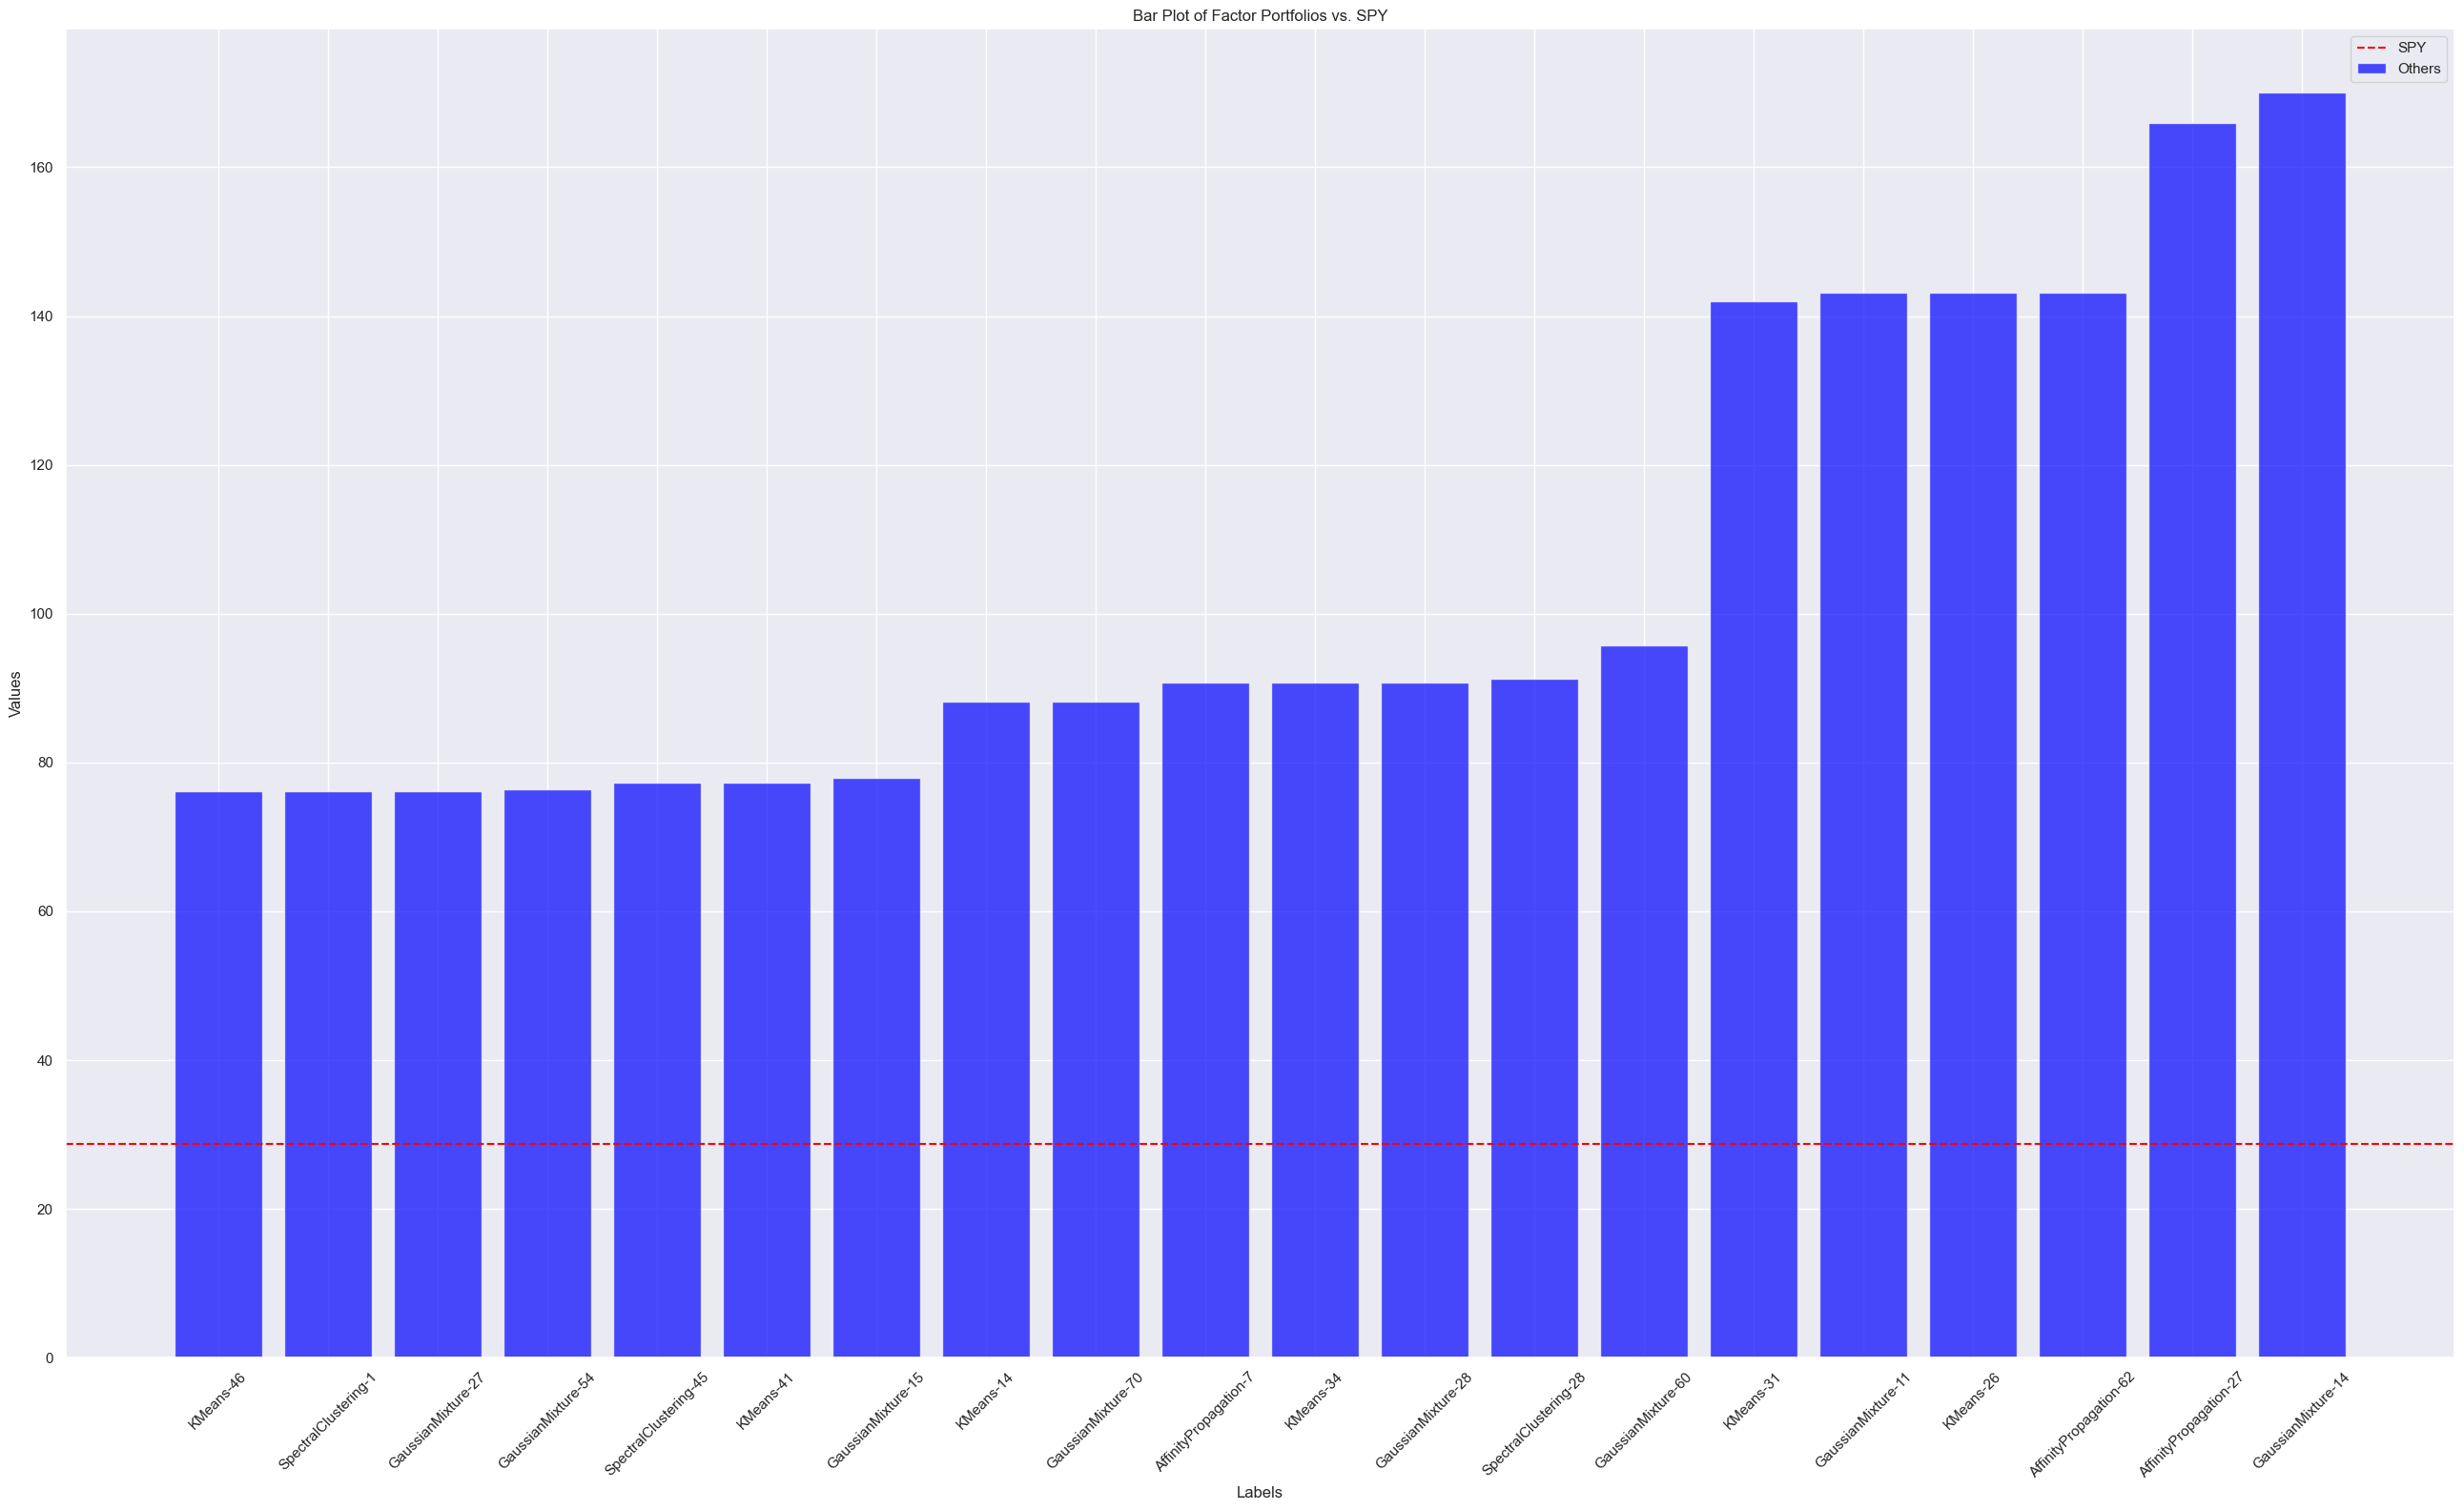

In [106]:
sum_returns = (1+(0.01 * weekly_returns.apply(pd.to_numeric, errors='coerce'))).prod(axis=1) - 1
top_20 = pd.DataFrame()
top_20['Returns'] = sum_returns
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'Returns'].values[0] * 100
top_20 = top_20.sort_values(by='Returns').tail(20)
plot_barplot(spy, top_20['Returns'].values * 100, top_20['Labels'].values)

C:\Users\food4thought\AppData\Local\Temp\ipykernel_6116\2705540600.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)


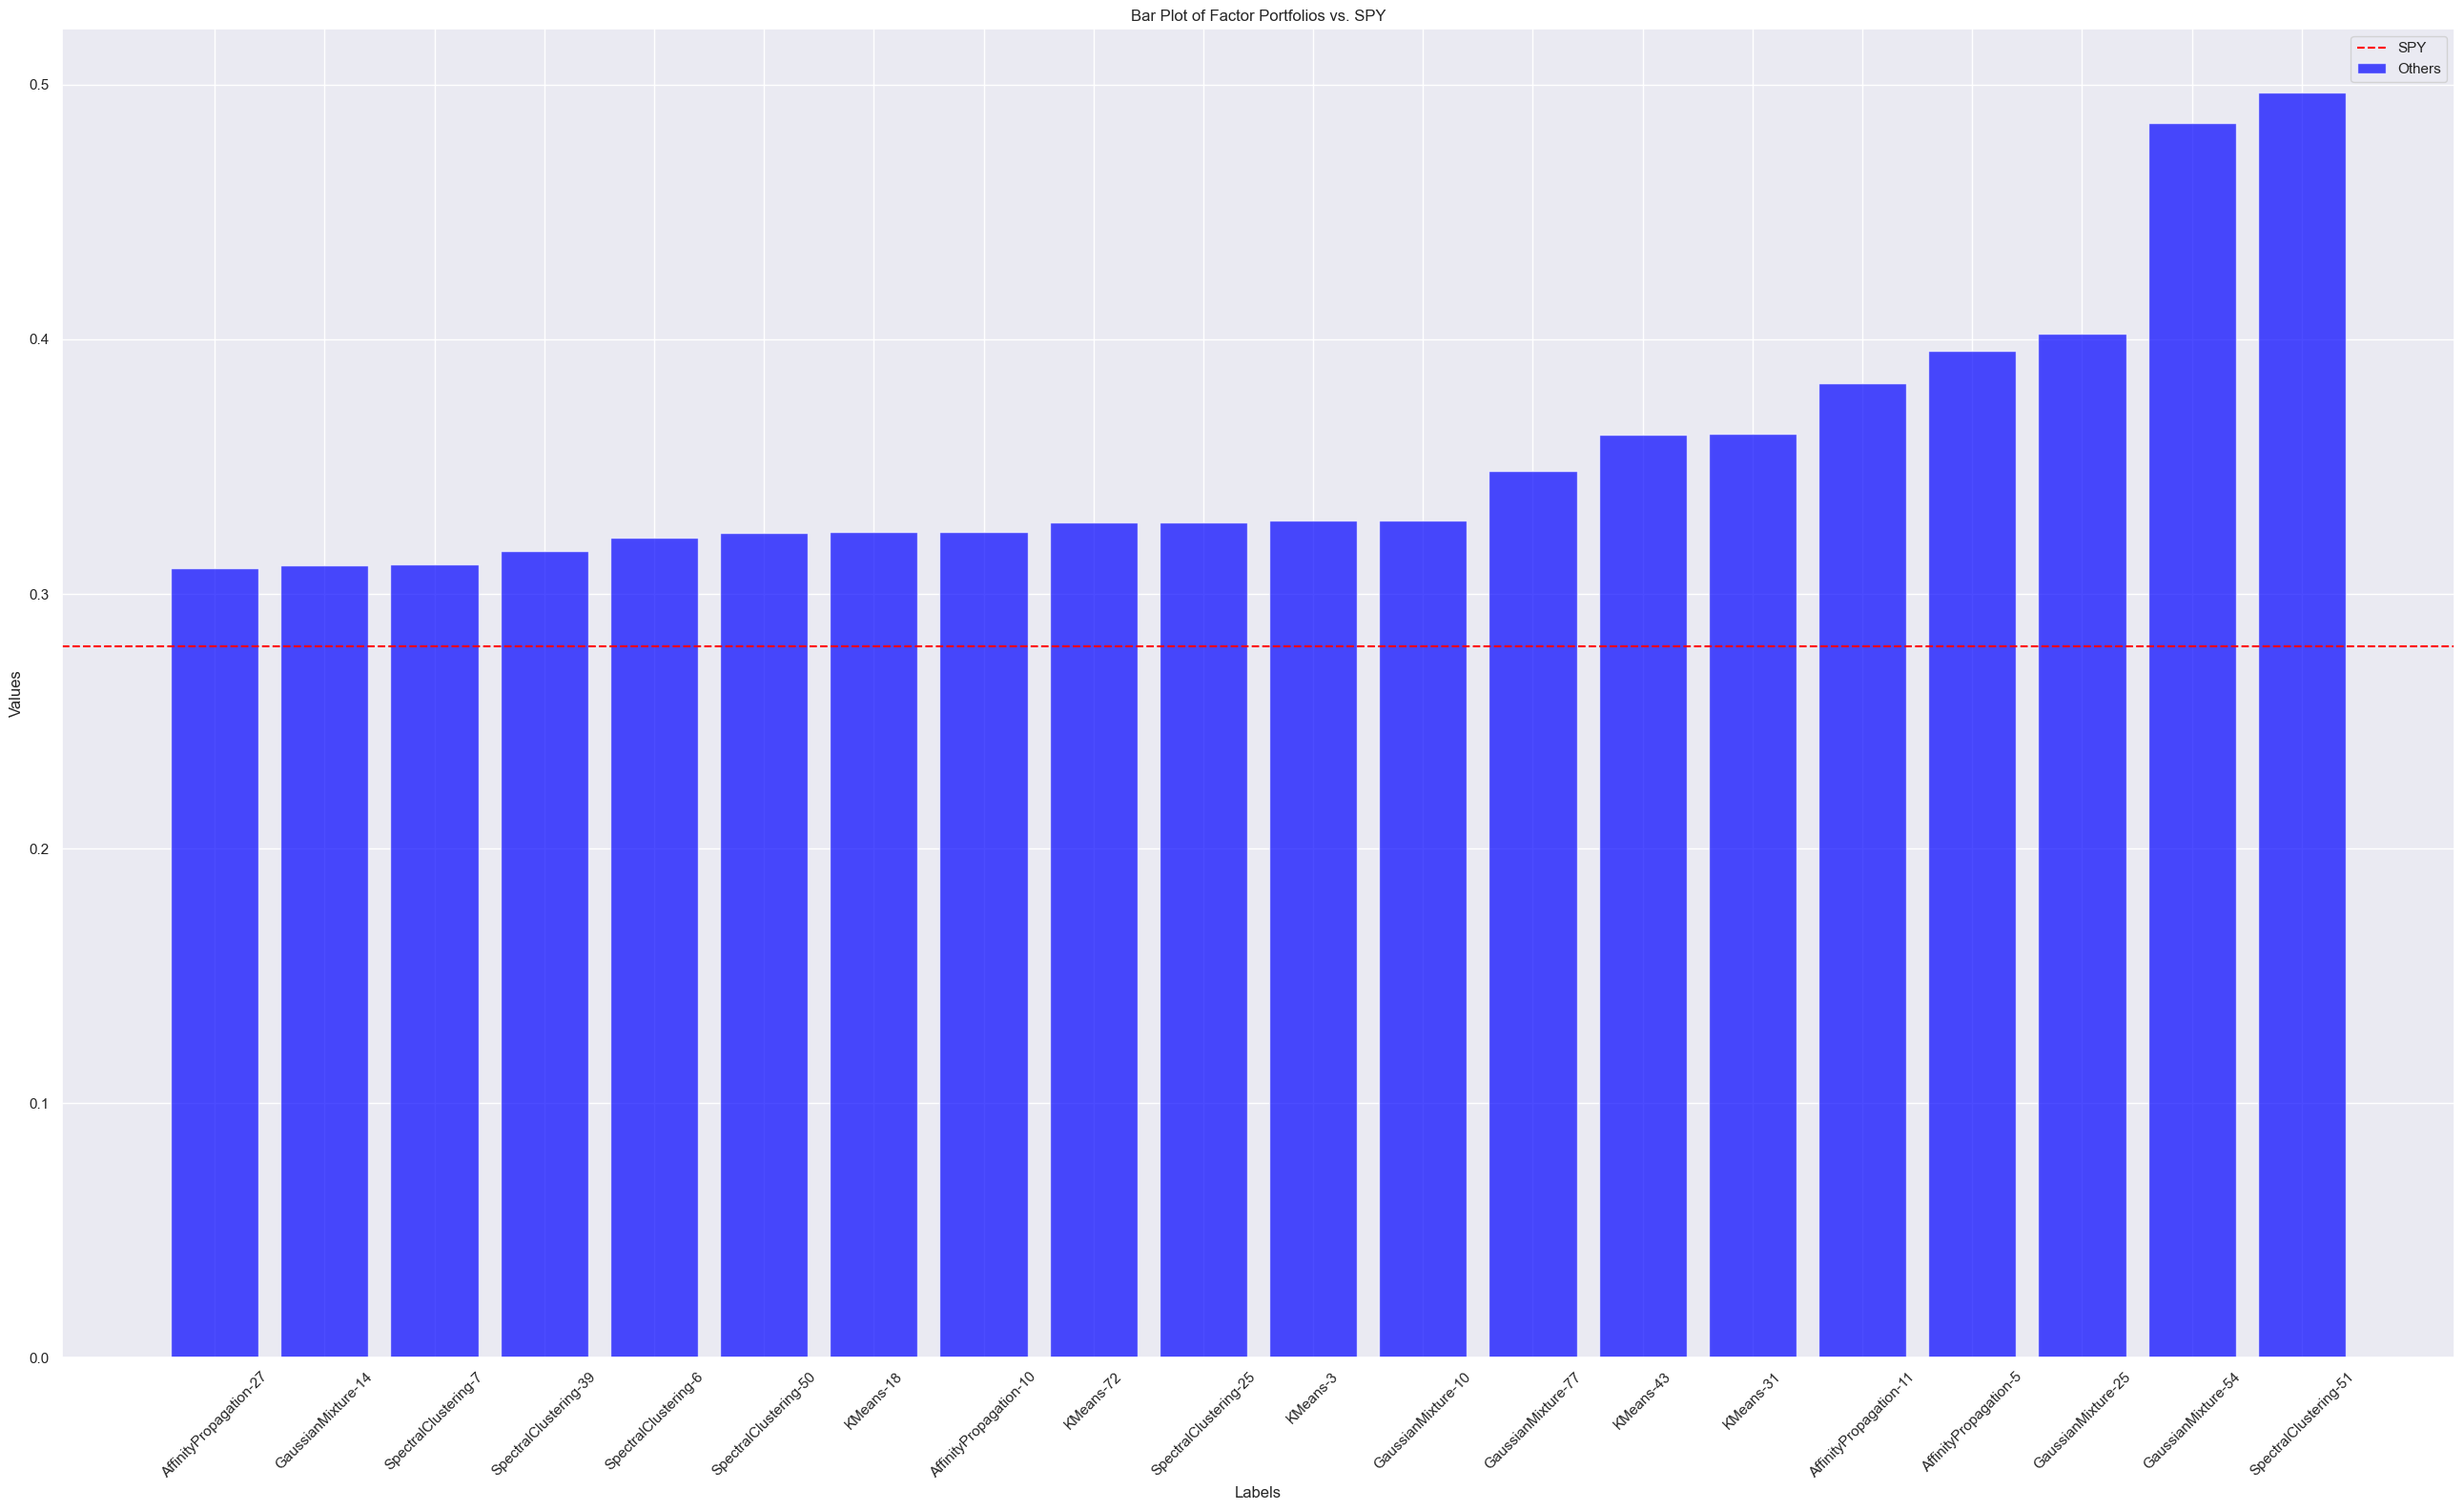

In [107]:
sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)
top_20 = pd.DataFrame()
top_20['SR'] = sharpe_ratios
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'SR'].values[0]
top_20 = top_20.sort_values(by='SR').tail(20)
plot_barplot(spy, top_20['SR'].values, top_20['Labels'].values)

In [109]:
weekly_returns = pd.read_csv('ReturnSeries\\2023-12-08\\FactorReturnsV3.csv')
weekly_returns.rename(columns={'Unnamed: 0':'Portfolio'}, inplace=True)
weekly_returns = weekly_returns[~weekly_returns['Portfolio'].str.match(r'.*\d$')]
weekly_returns

,Portfolio,2021-01-04 00:00:00,2021-01-11 00:00:00,2021-01-18 00:00:00,2021-01-25 00:00:00,2021-02-01 00:00:00,2021-02-08 00:00:00,2021-02-15 00:00:00,2021-02-22 00:00:00,2021-03-01 00:00:00,...,2021-11-01 00:00:00,2021-11-08 00:00:00,2021-11-15 00:00:00,2021-11-22 00:00:00,2021-11-29 00:00:00,2021-12-06 00:00:00,2021-12-13 00:00:00,2021-12-20 00:00:00,2021-12-27 00:00:00,2022-01-03 00:00:00
0,SPY,-1.3614,2.6845,-0.7896,2.3130,-2.1228,3.7956,0.5454,-1.4288,0.6589,...,0.9856,1.9324,-0.3199,0.0300,-0.6352,-1.2505,1.6958,-2.1371,4.8969,-0.4819
1,momentum,-0.1234,3.7592,-0.9067,2.1467,-1.0504,4.2481,1.3726,-1.2433,2.0990,...,0.1491,1.0472,-0.1377,-0.8054,-0.4552,-1.4750,0.9047,-2.2381,4.2180,0.0672
2,risk_adj_momentum,-0.1234,3.7593,-0.9067,2.1467,-1.0505,4.2322,1.3664,-1.2366,2.0869,...,0.1503,1.0562,-0.1385,-0.8089,-0.4572,-1.4778,0.9078,-2.2513,4.2572,0.0681
3,pe_op_basic,-1.1426,3.0570,-1.2704,0.3594,-1.0245,3.3323,1.3702,-1.9061,1.4188,...,0.5947,1.1612,-0.3376,-0.6678,-1.0394,-1.4173,1.1857,-2.2249,4.2699,-0.0824
4,bm,-1.4485,6.2609,0.9559,-1.0030,-2.9355,6.5032,0.6772,2.4047,1.4341,...,-0.6298,1.0526,0.4557,-1.5414,-1.6600,-0.0695,0.5182,-1.7368,4.7463,0.5192
5,1M_reversal,-1.6035,4.2379,-0.0725,0.1699,-2.3219,4.6673,0.8244,-0.0135,0.8995,...,-0.0016,1.2988,0.1613,-1.4140,-1.4670,-0.5232,0.9680,-1.9986,4.8118,0.3166
6,risk_adj_1M_reversal,-1.6035,4.2379,-0.0725,0.1699,-2.3219,4.6672,0.8244,-0.0135,0.8995,...,-0.0016,1.2996,0.1614,-1.4144,-1.4669,-0.5229,0.9681,-1.9979,4.8115,0.3167
69,AffinityPropagation-momentum-mcap,-0.2710,2.9832,-0.7859,2.4140,-1.0200,3.8704,0.8411,-0.9430,1.3753,...,0.2768,1.1602,-0.2355,-0.6545,-0.9410,-0.6730,1.0441,-2.2793,4.6015,0.2829
70,AffinityPropagation-risk_adj_momentum-mcap,-0.2710,2.9833,-0.7858,2.4140,-1.0201,3.8704,0.8411,-0.9430,1.3753,...,0.2768,1.1602,-0.2355,-0.6545,-0.9410,-0.6730,1.0441,-2.2795,4.6017,0.2832
71,AffinityPropagation-pe_op_basic-mcap,-1.2234,3.1767,-0.8661,1.4023,-1.7654,3.4454,0.7047,-1.7252,0.8787,...,0.8717,1.6680,-0.1254,-0.1107,-0.7499,-1.0670,1.6102,-1.9400,4.3789,0.0080


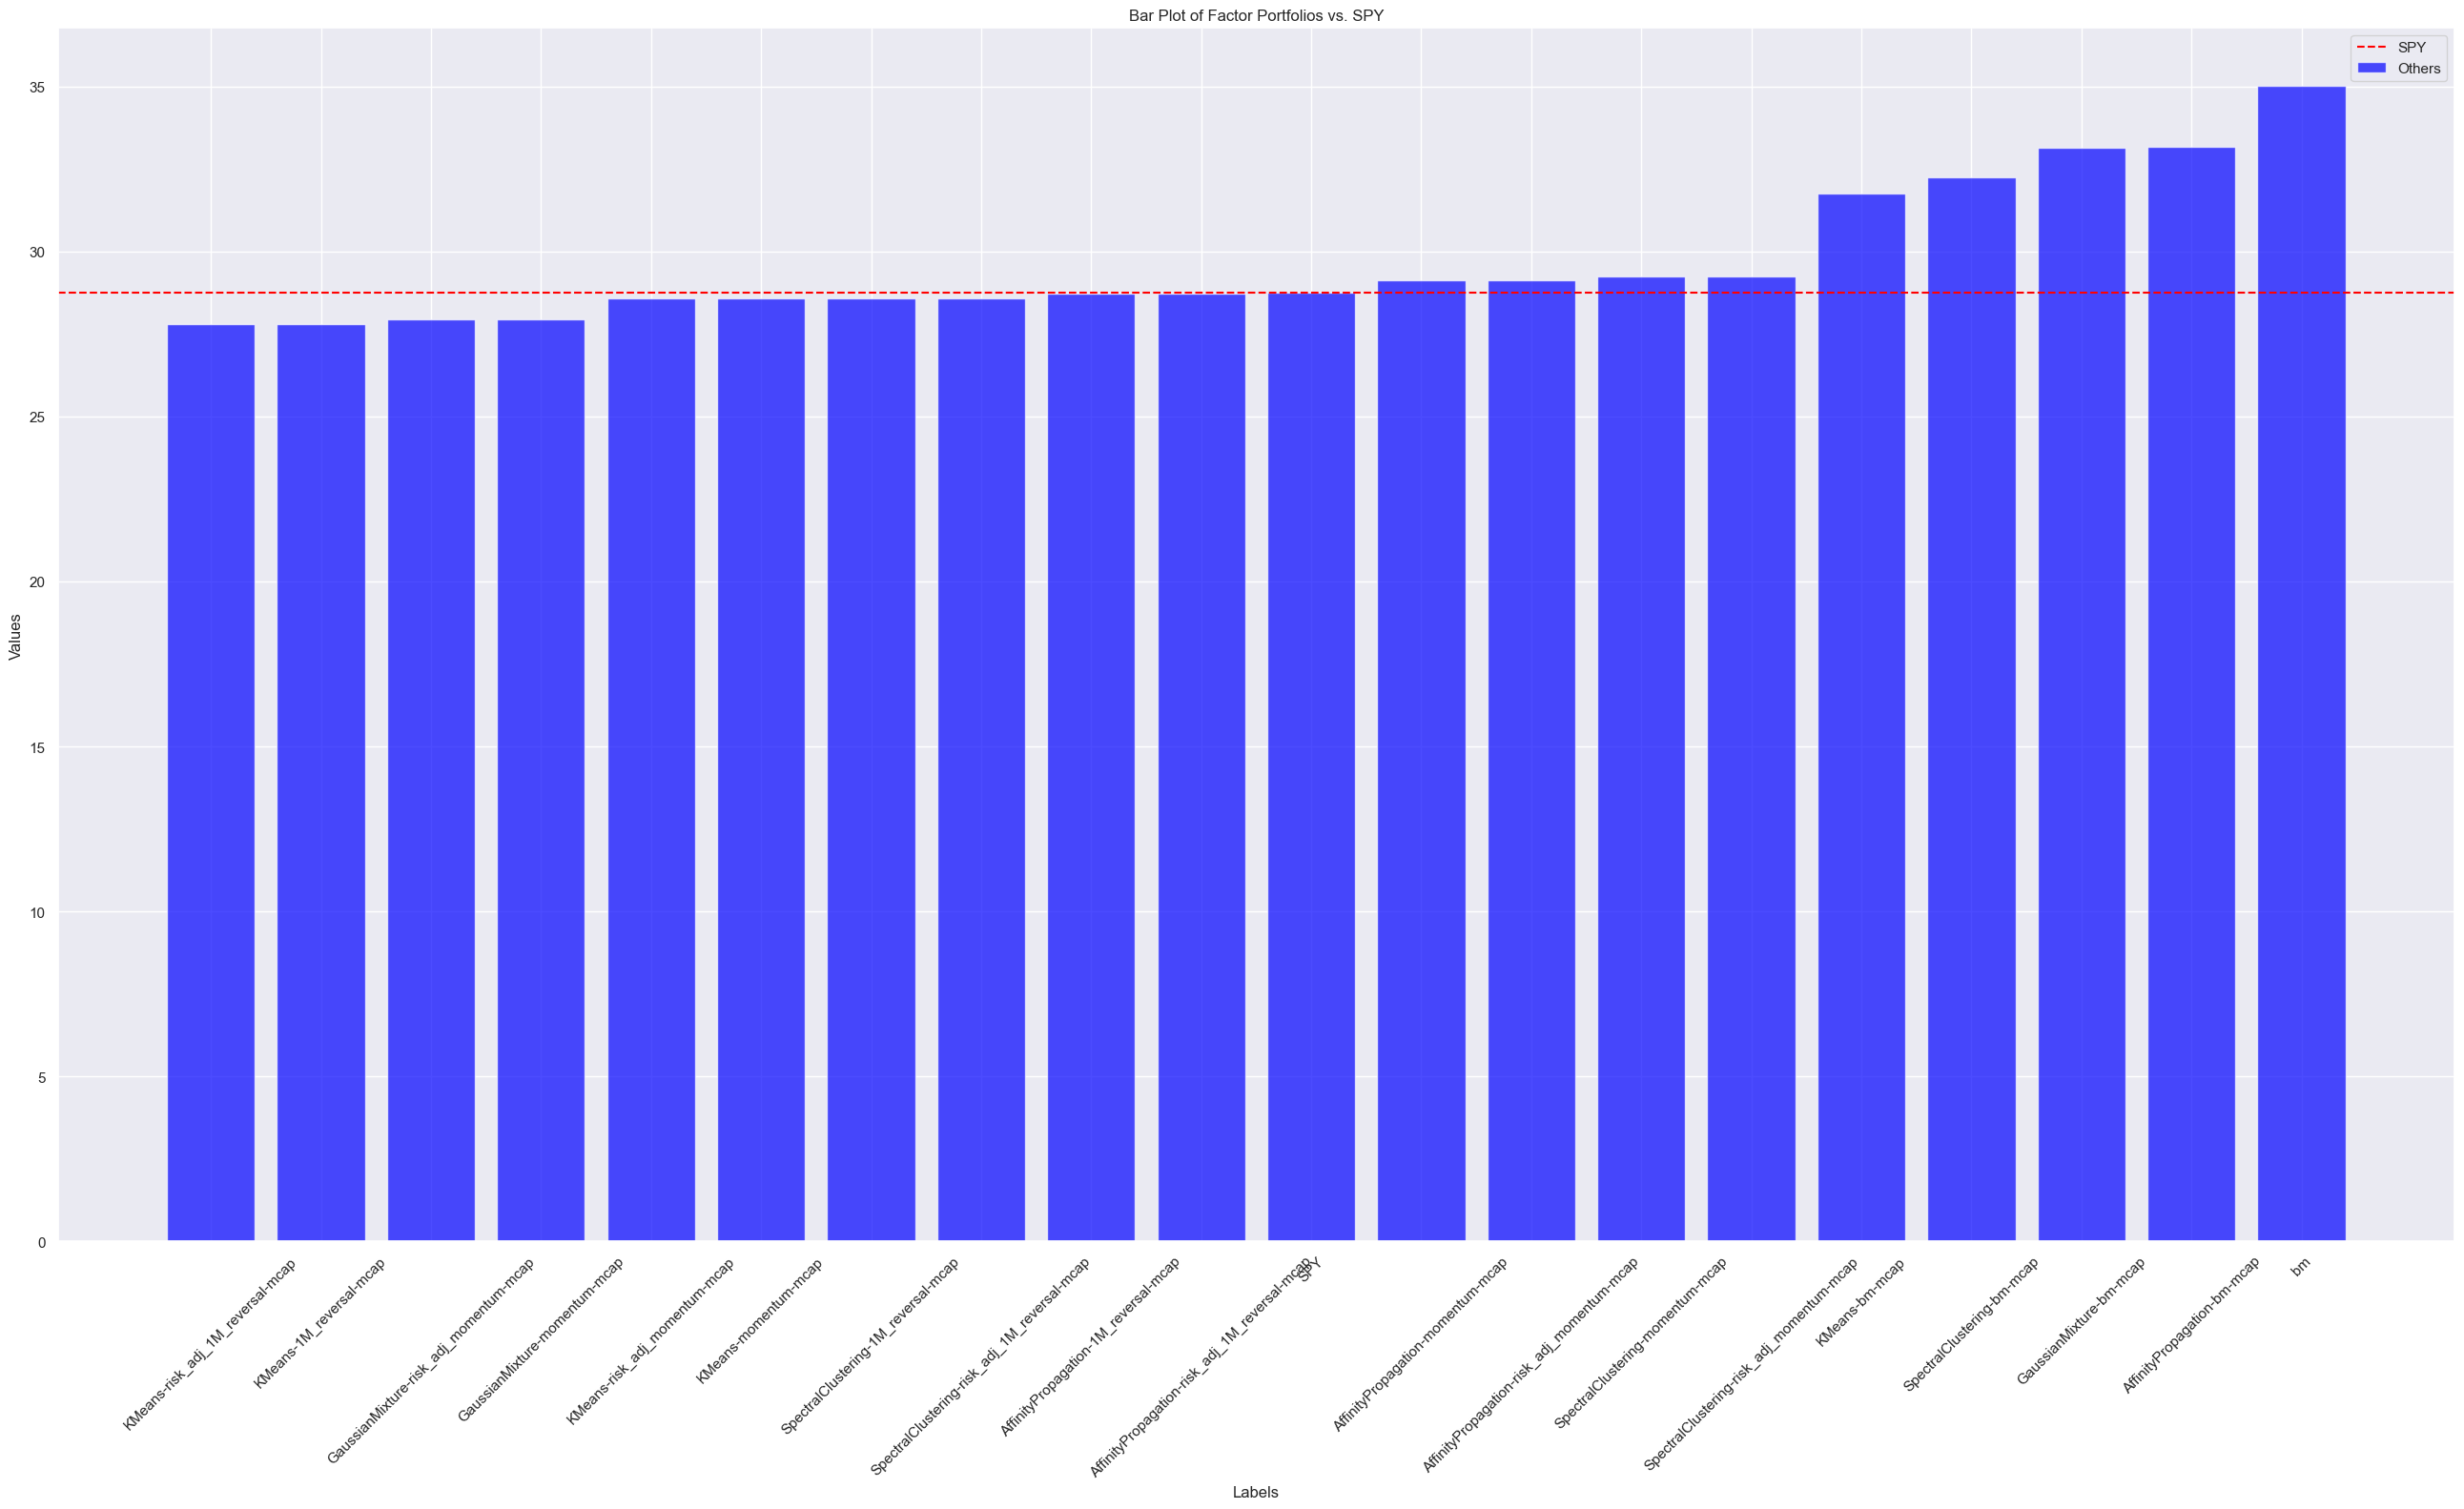

In [110]:
sum_returns = (1+(0.01 * weekly_returns.apply(pd.to_numeric, errors='coerce'))).prod(axis=1) - 1
top_20 = pd.DataFrame()
top_20['Returns'] = sum_returns
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'Returns'].values[0] * 100
top_20 = top_20.sort_values(by='Returns').tail(20)
plot_barplot(spy, top_20['Returns'].values * 100, top_20['Labels'].values)

C:\Users\food4thought\AppData\Local\Temp\ipykernel_6116\2705540600.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)


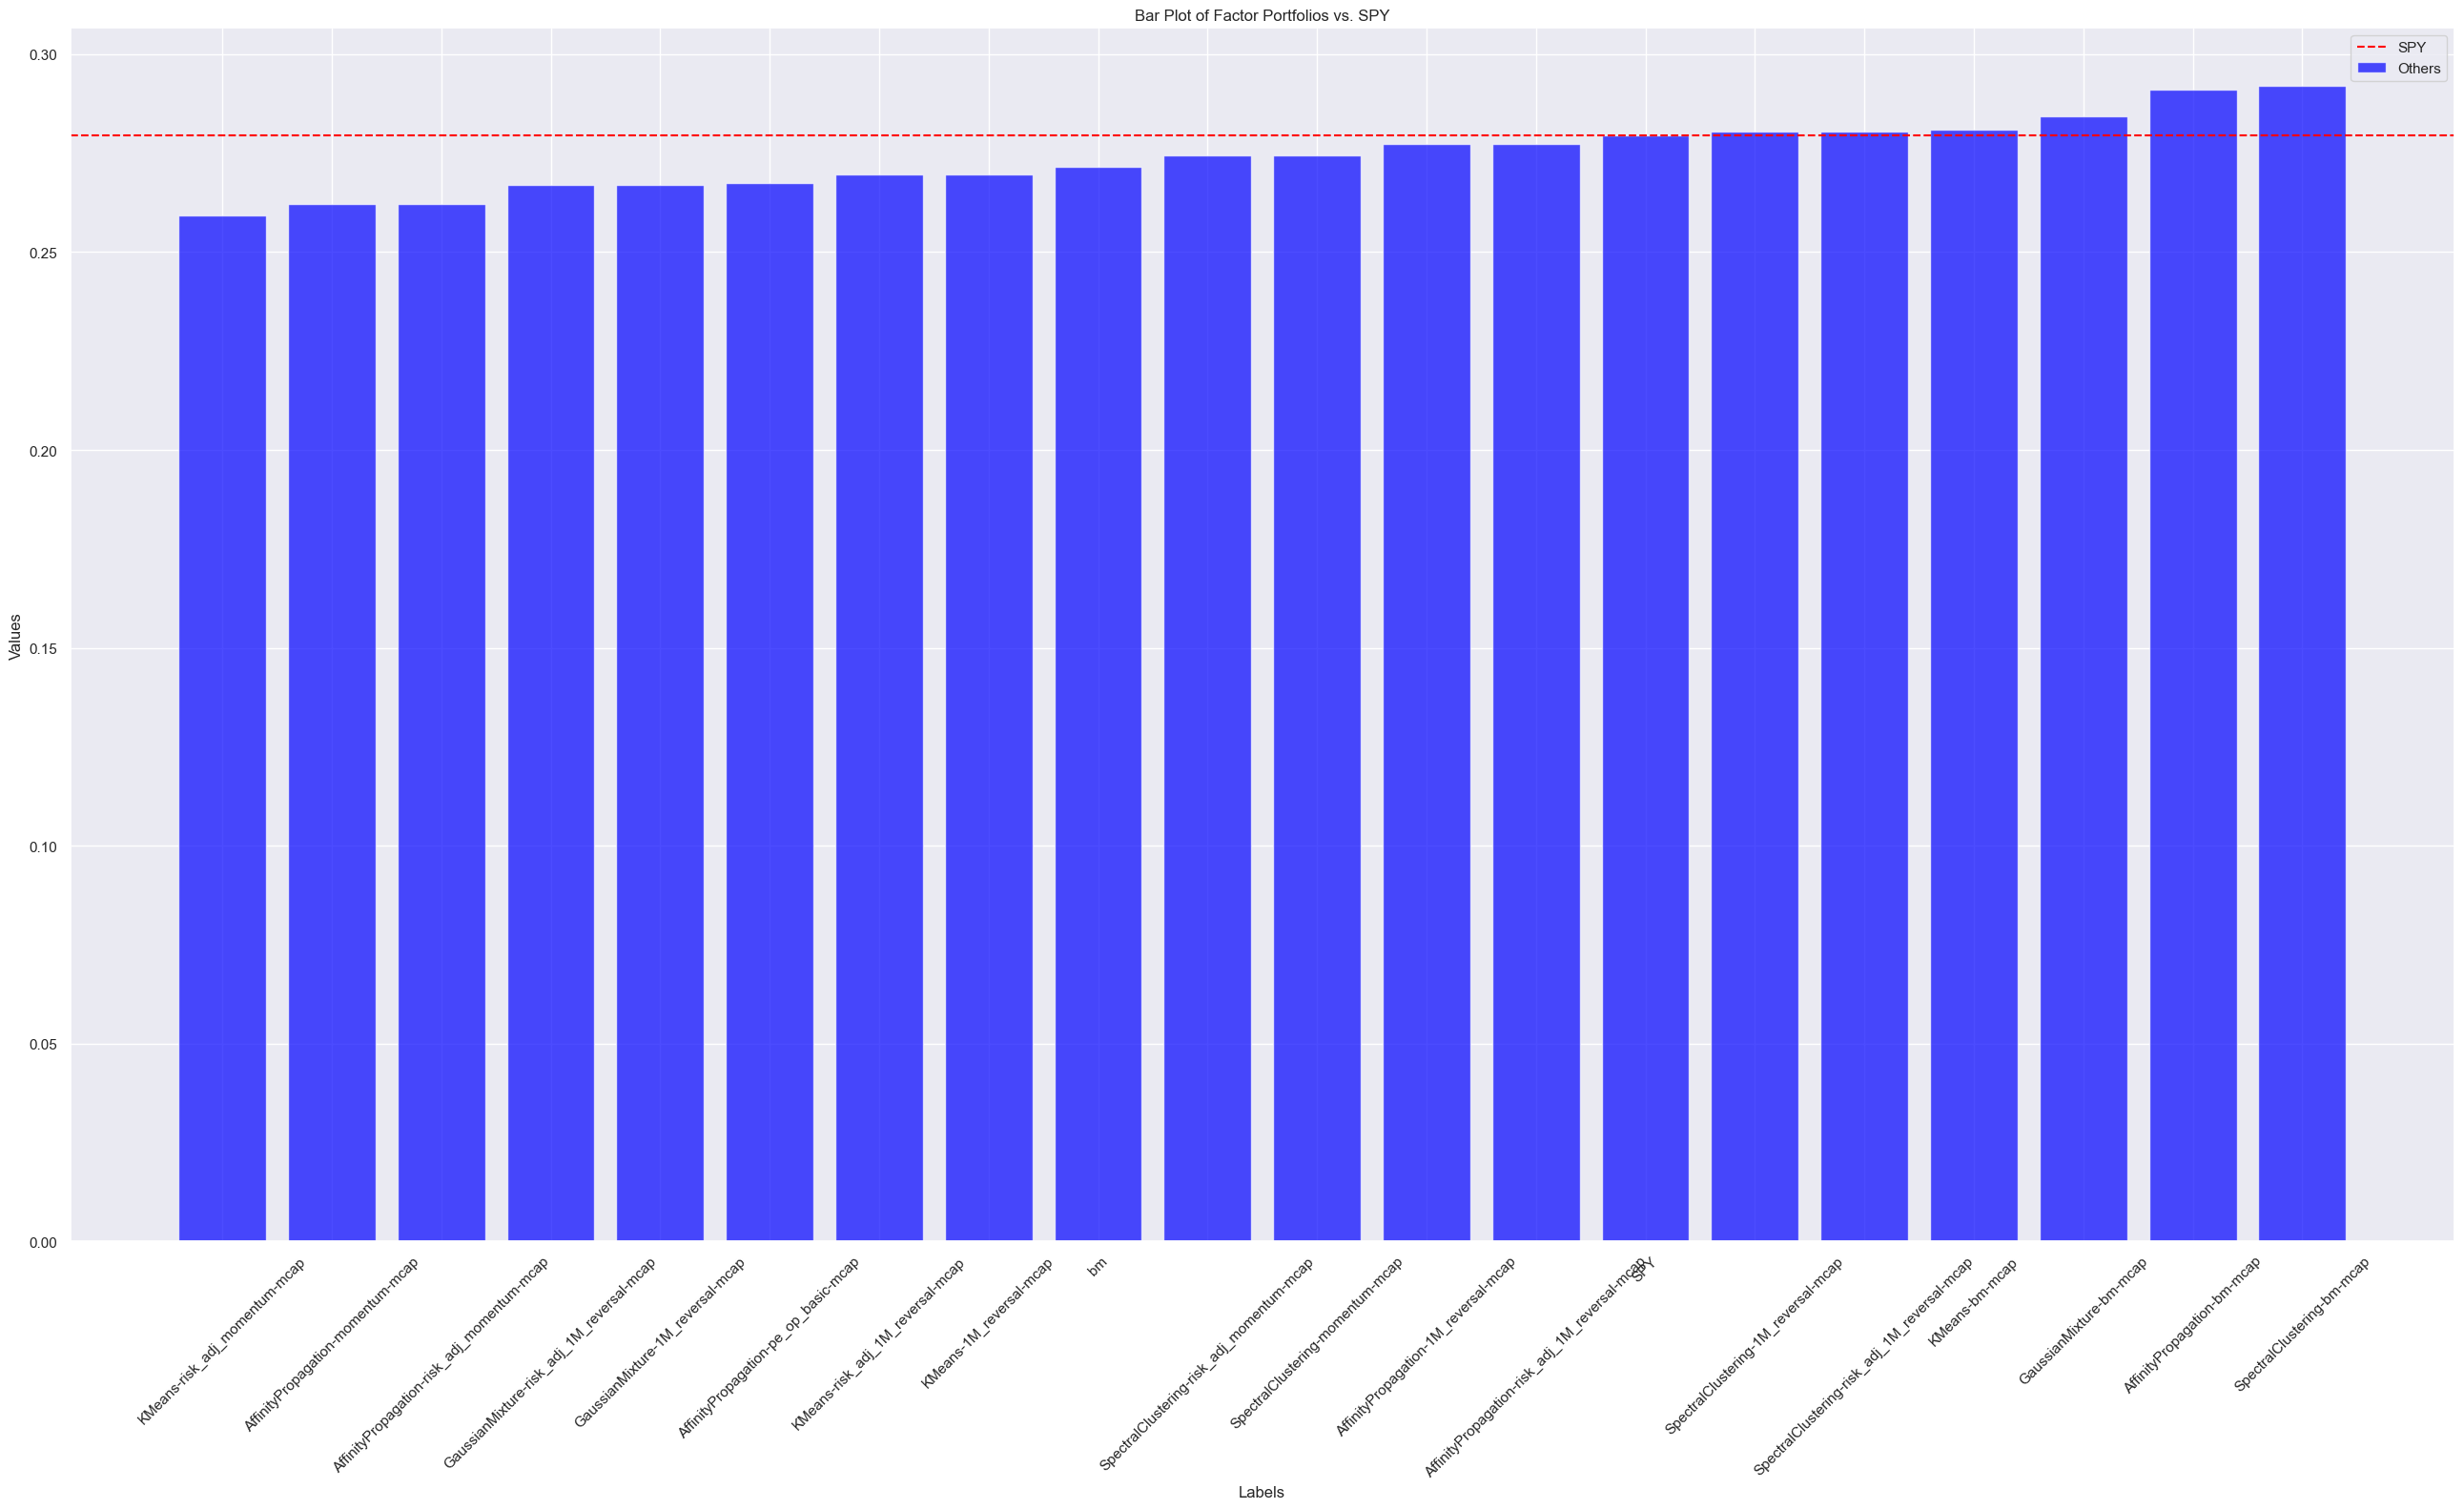

In [111]:
sharpe_ratios = weekly_returns.mean(axis=1) / weekly_returns.std(axis=1)
top_20 = pd.DataFrame()
top_20['SR'] = sharpe_ratios
top_20['Labels'] = weekly_returns['Portfolio'].values
spy = top_20.loc[top_20['Labels']=='SPY', 'SR'].values[0]
top_20 = top_20.sort_values(by='SR').tail(20)
plot_barplot(spy, top_20['SR'].values, top_20['Labels'].values)